===================================================
### Code developed by: Yushen Lin

### Contact: yl2020@ic.ac.uk
===================================================

In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Import to the current path
import os
os.chdir('/content/gdrive/MyDrive/dimension reduction') # change this dir once you are in the different one

In [ ]:
!pip install vtk -q

     |████████████████████████████████| 59.5 MB 42 kB/s 
     |████████████████████████████████| 495 kB 59.5 MB/s 
     |████████████████████████████████| 3.1 MB 45.8 MB/s 
     |████████████████████████████████| 3.0 MB 67.7 MB/s 
     |████████████████████████████████| 74 kB 3.6 MB/s 
     |████████████████████████████████| 251 kB 82.2 MB/s 
     |████████████████████████████████| 1.3 MB 71.3 MB/s 
     |████████████████████████████████| 142 kB 74.3 MB/s 
     |████████████████████████████████| 294 kB 77.2 MB/s 


In [ ]:
#ensuring the script runs correctly + in the correct %dirs
!python vtktools.py

In [ ]:
# Imports
from math import *
import sys, os
import numpy as np
import vtk
import vtktools
import matplotlib.pyplot as plt
import datetime, time
import numpy.linalg as la
import joblib
import h5py

import pandas as pd
import pprint as pprint

In [ ]:
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# automatically check the name of notebook
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

In [ ]:
notebookName

<a name = Prepare-data></a>
# Prepare data

## use Wget
get results in the other way

In [ ]:
!mkdir ClarenceCentre_wget
!wget https://www.dropbox.com/s/wmzopedxcelzpaf/ClarenceCentre.zip?dl=0
!unzip AADmtVChECW_B85M8O2cDmR0a -d './ClarenceCentre_wget/'
!rm -rf AADmtVChECW_B85M8O2cDmR0a

## Extract $CO_{2}$ data 

In [ ]:
def loadvtufile(path, name_simu, fieldname, vtu_start, vtu_end, vtu_step):
    """
    Read in .vtu files for a particular field
    
    Parameters
    ----------
    path : str 
        path to the folder containing the .vtu files
    name_simu : str
        name of the simulation data
    field_name : str
        field to read in e.g. CO2_ppm 
    vtu_start : int
        file number to start reading from  
    vtu_end : int
        file number to read up to
    vtu_step : int
        how many files to step across
    Returns
    -------
    numpy.ndarray 
        Returns the data from a particular field 
    """
    tic = time.time()
    
    extension = '.vtu'
    
    all_data = []

    #---------------------------------------------------------------------
    # EXTRACT DATA
    #---------------------------------------------------------------------
    for vtuID in range(vtu_start,vtu_end + 1,vtu_step):
        filename=path+name_simu+'_'+str(vtuID)+extension
        print ('\n  '+str(filename))

        vtu_data = vtktools.vtu(filename)
        data     = vtu_data.GetField(fieldname)
        #print (data)
        all_data.append(data)


    toc = time.time() #added 
    print ('\n\nTime : ', toc - tic, 'sec')
    return np.array(all_data)
    #pprint.pprint(data)

In [ ]:
path = '/content/gdrive/MyDrive/dimension reduction/ClarenceData/'
name_simu = 'ClarenceCentre'
vtu_start = 0
vtu_end   = 454
vtu_step  = 1

## Load carbon dioxide and velocity data and save

In [ ]:
CO2data = loadvtufile(path, name_simu, 'CO2_ppm', vtu_start, vtu_end, vtu_step) # Time: 1972.979228258133 sec
Udata = loadvtufile(path, name_simu, 'Velocity', vtu_start, vtu_end, vtu_step)

In [ ]:
# save both Velocity and CO2 data into pkl files
#joblib.dump(CO2data, "CO2data.pkl")
#joblib.dump(Udata, "Udata.pkl")

In [ ]:
CO2data = joblib.load("CO2data.pkl")
Udata = joblib.load("Udata.pkl")

## Standardise the Data 
Using the library `StandardScaler` from `sklearn.preprocessing` we implement this following formula for each node in the dataset $x$:
$$
\overline{x} = \frac{x - \mu}{\sigma}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the dataset. Standardising the data will ensure that the new mean $\overline{\mu} = 0$ and the new standard deviation $\overline{\sigma} = 1$. Reasons for doing this included here: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [ ]:
nfiles = CO2data.shape[0]
nNodes = CO2data.shape[1]
xdata = Udata[:,:,0]
ydata = Udata[:,:,1]
zdata = Udata[:,:,2]
CO2_data = CO2data.reshape((nfiles, nNodes))
CO2_data.shape

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

'''
MinMaxScalar:

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min
'''

# ************************************ -1 1 ************************************ #
scaler_std = MinMaxScaler((-1, 1))
scaler_x = MinMaxScaler((-1, 1))
scaler_y = MinMaxScaler((-1, 1))
scaler_z = MinMaxScaler((-1, 1))

scaler_std.fit(CO2_data)
scaler_x.fit(xdata)
scaler_y.fit(ydata)
scaler_z.fit(zdata)

# Apply transform to both the training set and the test set.
norm_co2 = scaler_std.transform(CO2_data)
norm_x = scaler_x.transform(xdata)
norm_y = scaler_y.transform(ydata)
norm_z = scaler_z.transform(zdata)

# ************************************ 0 1 ************************************ #
# scale the data for the compression methods that require scaler from 0 to 1
scaler_std_0 = MinMaxScaler((0, 1))
scaler_x_0 = MinMaxScaler((0, 1))
scaler_y_0 = MinMaxScaler((0, 1))
scaler_z_0 = MinMaxScaler((0, 1))

scaler_std_0.fit(CO2_data)
scaler_x_0.fit(xdata)
scaler_y_0.fit(ydata)
scaler_z_0.fit(zdata)

# Apply transform to both the training set and the test set.
norm_co2_0 = scaler_std_0.transform(CO2_data)
norm_x_0 = scaler_x_0.transform(xdata)
norm_y_0 = scaler_y_0.transform(ydata)
norm_z_0 = scaler_z_0.transform(zdata)

print("Standardised CO2 data")
print(norm_co2)
print("Standardised Velocity data (x, y, z)")
print(norm_x)
print(norm_y)
print(norm_z)

print("Standardised CO2 data")
print(norm_co2_0)
print("Standardised Velocity data (x, y, z)")
print(norm_x_0)
print(norm_y_0)
print(norm_z_0)

In [ ]:
# print out the number of 0 between each scaler
print(f"Number of Zeroes in -1 1 --> {norm_co2.size - np.count_nonzero(norm_co2)}")
print(f"Number of Zeroes in 0 1 --> {norm_co2_0.size - np.count_nonzero(norm_co2_0)}")

In [ ]:
# check scaling, if the mean of values that are normlised is 0, standard deviation = 1.
# if use MinMaxScalar, check if the data is evenly distributed.

print("CO2 mean ", np.sum(norm_co2[:,6])/len(norm_co2[:,6]))
print("x mean ", np.sum(norm_x[:,0])/len(norm_x[:,0]))
print("y mean ", np.sum(norm_y[:,0])/len(norm_y[:,0]))
print("z mean ", np.sum(norm_z[:,0])/len(norm_z[:,0]))
print("  ")
print("CO2 std ", np.std(norm_co2[:,1]))
print("x std ", np.std(norm_x[:,1]))
print("y std ", np.std(norm_y[:,0]))
print("z std ", np.std(norm_z[:,5]))

print(norm_co2.shape)
print(norm_x.shape)
print(norm_y.shape)
print(norm_z.shape)

## Create Snapshot Matrix
The snapshot matrix $\mathbf{\underline{S}}$ takes the form:
$$dim (\mathbf{\underline{S}}) = \text{no. data points/nodes} \times (\text{no. } CO_2 \text{ dimensions} + \text{no. Velocity dimensions}) \times \text{no. of timesteps}$$
For each timestep, we have $CO_2$ data and velocity data. 

In [ ]:
# ************************************ -1 1 ************************************ #
alldata1 = np.concatenate((norm_co2, norm_x), axis=1)
alldata2 = np.concatenate((alldata1, norm_y), axis=1)
alldata = np.concatenate((alldata2, norm_z), axis=1)

# Check the shape of the array
print("initial shape", alldata.shape)
all_values = alldata
print("Snapshot Matrix shape", all_values.shape)


# ************************************ 0 1 ************************************ #
alldata1 = np.concatenate((norm_co2_0, norm_x_0), axis=1)
alldata2 = np.concatenate((alldata1, norm_y_0), axis=1)
alldata = np.concatenate((alldata2, norm_z_0), axis=1)

# Check the shape of the array
print("initial shape", alldata.shape)

all_values_0 = alldata
print("Snapshot Matrix shape scale from 0 to 1", all_values_0.shape)

In [ ]:
# save the scalers and values for scaler from -1 to 1
joblib.dump(all_values, 'snapshot_matrix.pkl')
joblib.dump(scaler_std, 'scaler_std_full.pkl')
joblib.dump(scaler_x, 'scaler_x_full.pkl')
joblib.dump(scaler_y, 'scaler_y_full.pkl')
joblib.dump(scaler_z, 'scaler_z_full.pkl')

In [ ]:
# save the scalers and values for scaler from 0 to 1
joblib.dump(all_values_0, 'snapshot_matrix_0.pkl')
joblib.dump(scaler_std_0, 'scaler_std_full_0.pkl')
joblib.dump(scaler_x_0, 'scaler_x_full_0.pkl')
joblib.dump(scaler_y_0, 'scaler_y_full_0.pkl')
joblib.dump(scaler_z_0, 'scaler_z_full_0.pkl')

## Example of POD and PCA
Example of the same results of singular value from PCA and SVD
eigenvectors will be showing the direction of spread of the data, while eigenvalues will be indicating the magnitude of this spread

In [ ]:
from sklearn.decomposition import PCA

# example array 
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
print('Shape X',X.shape)

print('mean that PCA calculates automatically', X.mean(axis=0), X.mean(axis=0).shape)

# subtract the mean (zero in this case)
U,S,VT = np.linalg.svd(X-X.mean(axis=0))  
print('Singular values from SVD',S)

pca = PCA(n_components=2)
y = pca.fit_transform(X)
print('Singular values from PCA',pca.singular_values_) 
print('R matrix: ',y)
print('shape of y: ',y.shape)
print('orthonormalised basis functions from PCA:')
print(y[:,0])
print(y[:,1])

print('\t')
print('U in SVD: ',U)
print('These are the same as POD up to multiplication by (-1).')

Reduced variable a associated with a snapshot is mentioned in the equation 19 of the paper 'An autoencoder-based reduced-order model for eigenvalue problems with application to neutron difusion'.

## ***Method 1***: Use PCA to reduce dimension reduction from sklearn

In [ ]:
# load data that has been stanardlised
all_values = joblib.load('snapshot_matrix.pkl') # dtype('float64')

In [ ]:
# load data into h5 file in order to reduce the load of RAM when dealing with large array
f=h5py.File("all_values_h.hdf5","w")
d1=f.create_dataset("dset1",data=all_values, dtype='<f8')
f.close()

In [ ]:
# load this when load the h5 data of all_values
f=h5py.File("all_values_h.hdf5","r")
list(f.keys())

In [ ]:
dset = f['dset1'] # dtype('<f8')
f.close()
print(dset.dtype)

## check distribution of data(h5)
x-axis is the interval of scaling within the range -1 to 1,
y axis is the frequency of a particular bin.

Use h5 file is needed otherwise the RAM will just ran out quickly in local machine or on Google Colab.

Refer to the diagram in the report.


In [ ]:
# plot the hist graph
his = plt.figure()
his_plot = his.add_subplot(111)
counts, bins, patches = his_plot.hist(dset, density=True, linewidth=0)
plt.gca().set_xlim(all_values.min(), all_values.max())
plt.show()
f.close()

In [ ]:
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
# p_tot -> proportion of the variance we want to keep
p = 0.999
p_tot = 0.9999999999999995

time0 = time.time()
pca = PCA(p_tot)
train_pca = pca.fit_transform(all_values)
time1 = time.time()

print(train_pca.shape)
print('Computational time of PCA', time1-time0)

# reducing the dimensionality
X_recovered = pca.inverse_transform(train_pca)
np.allclose(X_recovered, all_values)

In [ ]:
# Explained variation: explained variation measures the proportion to which a mathematical model accounts for the variation (dispersion) of a given data set.

p = 0.995
cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
d_tot = pca.n_components_
# Find the number of principle components 
d = np.argmax(cumsum_eig >= p) + 1
print("initial number of components = ", d_tot)
print("number of components after PCA = ", d)

In [ ]:
# Define the function of calculating the max absolute error and mean absolute error.
def calculator(X_train_1D, X_train_1D_recovered):
  abs_error = abs(X_train_1D - X_train_1D_recovered)
  perc_error = abs_error*100/abs(X_train_1D)
  
  print('max_abs_error: ',np.max(abs(X_train_1D - X_train_1D_recovered)) )
  print('mean_abs_error: ',np.mean(abs(X_train_1D - X_train_1D_recovered)) )

In [ ]:
# n_components is the dimension we want to reduce to
# Create an instance of the PCA model
pca_compress = PCA(n_components=d)
X_train_pca = pca_compress.fit_transform(all_values)
X_recovered = pca_compress.inverse_transform(X_train_pca)

print(X_train_pca.shape)
calculator(all_values,X_recovered)
mean_squared_error(all_values,X_recovered)

In [ ]:
scaler_std = joblib.load('scaler_std_full.pkl')
scaler_x = joblib.load('scaler_x_full.pkl')
scaler_y = joblib.load('scaler_y_full.pkl')
scaler_z = joblib.load('scaler_z_full.pkl')

In [ ]:
X = np.hsplit(X_recovered, 4)
S_CO2 = scaler_std.inverse_transform(X[0])
S_x = scaler_x.inverse_transform(X[1])
S_y = scaler_y.inverse_transform(X[2])
S_z = scaler_z.inverse_transform(X[3])
print(S_CO2)

In [ ]:
import vtktools
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

def write_example_to_vtu(exm_num,verbose,datapath):
  # get clean vtu file
  if (verbose==True):
    snapshot_data_location = '/content/gdrive/MyDrive/dimension reduction/ClarenceData/' # chang ethis data_location once your dir is changed
    snapshot_file_base = 'ClarenceCentre_'
    filename = snapshot_data_location + snapshot_file_base + '0.vtu'
    clean_vtu = get_clean_vtu_file(filename)
    nNodes = 148906
    # write results to vtu
    #nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base) 
    CO2_ppm = np.zeros((nNodes,1))
    velocity = np.zeros((nNodes,3))

    new_vtu = vtktools.vtu()
    new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
    new_vtu.filename = '/content/gdrive/MyDrive/dimension reduction/ClarenceData/Predictions/PCA_recover/'+'datapath' + str(exm_num) + '.vtu'

    CO2_ppm[:] = S_CO2[exm_num].reshape((148906, 1),order='F')
    velocity[:,0] = S_x[exm_num].reshape((148906),order='F')
    velocity[:,1] = S_y[exm_num].reshape((148906),order='F') 
    velocity[:,2] = S_z[exm_num].reshape((148906),order='F') 
 
    new_vtu.AddField('CO2_ppm', CO2_ppm)
    new_vtu.AddField('Velocity', velocity)
    new_vtu.Write()

verbose=False
datapath = 'PCA_recover'
for i in range(455):
  write_example_to_vtu(i,verbose,datapath)

In [ ]:
def analysis_PCA():
  d = [1,2,4,8,16,32,64,128]
  MSE = []
  for i in d:
    pca_compress = PCA(n_components=i)
    X_train_pca = pca_compress.fit_transform(all_values)
    X_recovered = pca_compress.inverse_transform(X_train_pca)
    MSE.append(mean_squared_error(all_values,X_recovered))

  return MSE

In [ ]:
MSE = analysis_PCA()
MSE

In [ ]:
# save PCA compress data and its instance
joblib.dump(X_train_pca, 'pod_coefficients_full.pkl') 
joblib.dump(pca_compress, 'pca_compress_454_full.pkl')

## ***Method 2***: Use NMF to reduce dimension reduction from sklearn

In [ ]:
# load the data scaled from 0 to 1 as NMF requires non-negative
all_values_0 = joblib.load('snapshot_matrix_0.pkl') 

In [ ]:
from sklearn.decomposition import NMF

time_NMF = time.time()
model_NMF = NMF(n_components=43, init='random', random_state=0)
W = model_NMF.fit_transform(all_values_0)
H = model_NMF.components_
print('H',H)
print('W: ', W)
reconstuct_NMF = model_NMF.inverse_transform(W)
time_NMF_1 = time.time()
print('reconstuct_NMF: ',reconstuct_NMF)
print('loss of NMF:' )
mean_squared_error(reconstuct_NMF,all_values_0)
print('computational time of NMF: ', time_NMF_1 - time_NMF)
print('\t')

In [ ]:
# save NMF compress data
joblib.dump(model_NMF, 'output_files/model_NMF.pkl') 
joblib.dump(W, 'output_files/NMF_454_full.pkl')

In [ ]:
mean_squared_error(reconstuct_NMF,all_values_0)

In [ ]:
scaler_std_full_0 = joblib.load('scaler_std_full_0.pkl')
scaler_x_0 = joblib.load('scaler_x_full_0.pkl')
scaler_y_0 = joblib.load('scaler_y_full_0.pkl')
scaler_z_0 = joblib.load('scaler_z_full_0.pkl')

In [ ]:
reconstuct_NMF_paraview = model_NMF.inverse_transform(W)
X = np.hsplit(reconstuct_NMF_paraview, 4)
S_CO2 = scaler_std_full_0.inverse_transform(X[0])
S_x = scaler_x_0.inverse_transform(X[1])
S_y = scaler_y_0.inverse_transform(X[2])
S_z = scaler_z_0.inverse_transform(X[3])

In [ ]:
import vtktools
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file
# /content/gdrive/MyDrive/dimension reduction/ClarenceData/'
def write_example_to_vtu(exm_num,verbose,datapath):
  # get clean vtu file
  if (verbose==True):
    snapshot_data_location = '/content/gdrive/MyDrive/dimension reduction/ClarenceData/'
    snapshot_file_base = 'ClarenceCentre_'
    filename = snapshot_data_location + snapshot_file_base + '0.vtu'
    clean_vtu = get_clean_vtu_file(filename)
    nNodes = 148906
    # write results to vtu
    #nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base) 
    CO2_ppm = np.zeros((nNodes,1))
    velocity = np.zeros((nNodes,3))

    new_vtu = vtktools.vtu()
    new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
    new_vtu.filename = '/content/gdrive/MyDrive/dimension reduction/ClarenceData/Predictions/NMF/'+'datapath' + str(exm_num) + '.vtu'

    CO2_ppm[:] = S_CO2[exm_num].reshape((148906, 1),order='F')
    velocity[:,0] = S_x[exm_num].reshape((148906),order='F')
    velocity[:,1] = S_y[exm_num].reshape((148906),order='F') 
    velocity[:,2] = S_z[exm_num].reshape((148906),order='F') 
 
    new_vtu.AddField('CO2_ppm', CO2_ppm)
    new_vtu.AddField('Velocity', velocity)
    new_vtu.Write()

verbose=True
datapath = 'NMF'
for i in range(455):
  write_example_to_vtu(i,verbose,datapath)

## ***Method 3***: SVD autoencoder
This part is to compress the dimension **SVD** first. 
The length of the input to the autoencoder is one factor that governs the difficulty of training an autoencoder.
The longer these vectors are, the more parameters (weights) there are to be adjusted during optimisation, which increases the computational cost.

SVD reduces the length of the input from number of freedom **N** to the number of basis functoins (**P** where **P** << **N**)

$a$ = $R^{T}$ * snapshots

where a is reduced varible, R is basis functions

However, the normal SVD method is expensive to calculate especially for large matrix, the RAM in normal machine could not handle. One of the potential remedy is write the snapshots into h5 file (container) to save RAM which is provided in the code, and the other approach is as following:

### Get POD basis function
Define function of extracting POD basis function, the derivations of this function refer to eqs(15) in paper 'An autoencoder-based reduced-order model for eigenvalue problems with application to neutron diffusion'.  

Encode my snapshots then get latent varibles, just pass the snapshots into the encoder and out from the latent varibles

use U, choose how many columns we want for U, keep 20 columns, work out pod coefficient in each snapshot(it is in high dimensional representation, if it is CO2, it is number of nodes by 1, we want to turns to number of pod by 1, from 140000 by to 20 by 1), to do that pre multiply the transpose of U matrix

just multiply the R tranpose by the snapshot matrix to get pod coefficient, every time level in that matrix corresponds to an exmaple or sample

number of samples is number of feature

In [ ]:
#Instead of taking the svd of the snapshots matrix (S), you can see a method which applies 
#an eigendecomposition to (S^T S) and then works out the POD basis functions (eqs 15). (S^T S) will by
#5 by 5 in this case as I define the snapshots matrix to be nDoF by nSNapshots (ie the transpose of 
#your definition) so make sure that the matrix you calculate ((S^T S) or (S S^T)) is 5 by 5 and not 148906 by 148906.

# SVD
#The SVD is unable to compress the column that has 595624 representations because the RAM is ran out since SVD is extremely computational intensive.

def get_POD_functions(snapshots_matrix, nPOD, cumulative_tol, nNodes):
  
  nrows, ncols = snapshots_matrix.shape

  if nrows > ncols:
    SSmatrix = np.dot(snapshots_matrix.T, snapshots_matrix)
  else:
    SSmatrix = np.dot(snapshots_matrix, snapshots_matrix.T)
    print('NOOB DETECTED - CHECK OUT YOUR BASIS FUNCTIONS ARE CALCULATED WITH THIS METHOD')

  print('SSmatrix', SSmatrix.shape, 'snapshots_matrix', snapshots_matrix.shape)
  eigvalues, v = np.linalg.eigh(SSmatrix)
  eigvalues =  eigvalues[::-1]
  # get rid of small negative eigenvalues (there shouldn't be any as the eigenvalues of a real, symmetric
  # matrix are non-negative, but sometimes very small negative values do appear)
  eigvalues[eigvalues<0] = 0
  s_values = np.sqrt(eigvalues)
  nAll = len(eigvalues)
  
  if nPOD == -1:

    # truncation - the number of POD basis functions is chosen by seeing when the percentage 
    # of cumulative information captured by a certain number of POD basis functions reaches a
    # user-defined tolerance 
    # see https://onlinelibrary.wiley.com/doi/10.1002/nme.6681 for 
    # a brief explanation of truncation (section 3.2)

    # calculate cumulative information captured by the POD basis functions
    cumulative_info = np.zeros(len(eigvalues))
    for j in range(len(eigvalues)):
      if j==0:
        cumulative_info[j] = eigvalues[j]

      else: 
        cumulative_info[j] = cumulative_info[j-1] + eigvalues[j]

    cumulative_info = cumulative_info / cumulative_info[-1]

    nPOD = sum(cumulative_info <= cumulative_tol) #tolerance
  elif nPOD == -2:
    # keeping all the POD basis functions
    nPOD = nAll
  #else:
  #  the user has specified nPOD 

  print ("retaining", nPOD, "basis functions of a possible", nAll )

  basis_functions = np.zeros((nNodes,nPOD))
  for j in reversed(range(nAll-nPOD,nAll)):
    # v is eigenvector
    Av = np.dot(snapshots_matrix,v[:,j])
    # this is from eqs 15
    basis_functions[:,nAll-j-1] = Av/np.linalg.norm(Av)
 
  return basis_functions

### load basis function and pod coefficient


In [ ]:
# load POD basis function 
basis_func = np.loadtxt('basis_func.csv', delimiter=',')
# load pod coefficient
reduced_a = np.loadtxt('reduced_a.csv', delimiter=',')

In [ ]:
#all_values = joblib.load('snapshot_matrix.pkl') 
cumulative_tol = 0.9999

nPOD = all_values.shape[0]
nNodes = all_values.shape[1]
all_values_basis = all_values.T
basis_func = get_POD_functions(all_values_basis, nPOD, cumulative_tol, nNodes)

In [ ]:
# Reconstruction if the SVD is applied in the transpose
def orginal(S,R,RT):
  N = len(S)
  orginal = np.zeros([N,nNodes])
  for i in range(N):
    orginal[i,:] =  S[i,:]@ RT @ R
  return orginal

reconst_all_value = orginal(all_values,basis_func.T,basis_func)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(reconst_all_value,all_values)

In [ ]:
# calculate POD coefficient and save it for calculation or dimension reduction later
reduced_a = basis_func.T @ all_values.T
print(reduced_a)
#np.savetxt('reduced_a.csv', reduced_a, delimiter=',')

### **SVD**

Use numpy.linalg to calculate SVD.

In [ ]:
# calculate Mean square error 
def MSE(S, index, R, RT,verbose = True):
  m = zeros([len(index),nNodes])
  n = zeros([len(index),nNodes])
  for i in range(len(index)):
    if (verbose == True): 
      m[i,:] = S[index[i],:] - S[index[i],:]@ RT @ R
    else:
      m[i,:] = S[index[i],:] - S[index[i],:]@ R @ RT
  return m.mean()

# Reconstruction
def orginal(S,R,RT,verbose = True):
  N = len(S)
  orginal = np.zeros([N,nNodes])
  for i in range(N):
    if (verbose == True):
      orginal[i,:] =  S[i,:]@ RT @ R
    else:
      orginal[i,:] =  S[i,:]@ R @ RT
  return orginal

train_index = []
for i in range(455):
  train_index.append(i)

In [ ]:
# try to apply it on whole dataset
u,sigma,v= np.linalg.svd(dset,False)
print(u.shape)
print(sigma.shape)
print(v.shape)

In [ ]:
from scipy.linalg import diagsvd
R = u[0:32,:]
RT = R.transpose()
print(RT.shape)
nNodes = 455

reconstruction = orginal(u,R,RT,verbose=True)
print("The MSE: ",MSE(dset, train_index, R, RT,verbose=False))
print('reconst: ',reconstruction, reconstruction.shape)

In [ ]:
# POD basis matrix
R = u[0:32,:]
print(R.shape)
RT = R.transpose()
print(RT.shape)
nNodes = 455

reconstruction = orginal(reduced_a, R,RT)
np.allclose(reconstruction, reduced_a, atol = 2)

#### Anaylsis SVD

In [ ]:
def analysis_SVD(num_reduce):
  # apply SVD
  if (num_reduce < 1):
    assert 'the number of dimension that is reduced to should be greater than 0, thanks for your coorporation.'
  vt,sigma2,u= la.svd(reduced_a,False)
  # POD basis matrix
  R = u[0:num_reduce,:]
  RT = R.transpose()
  MS_error = MSE(reduced_a, train_index, R, RT)
  print("The MSE: ",MS_error)
  return MS_error

In [ ]:
def output_analysation():
  num_reduce = [1,2,4,8,16,32,64,128]
  output_MSE = []
  for i in num_reduce:
    MSE = analysis_SVD(i)
    output_MSE.append(MSE)

  return np.abs(output_MSE)
MSE_SVD = output_analysation()  
print('MSEs of SVD: ',MSE_SVD)

### Define the structure of autoencoder

The early stopping is used for training, the data is compressed from 455 to 43.

activation function we choose here is **ELU**. ELU is a function that tend to converge cost to zero faster and produce more accurate results. Different to other activation functions, ELU has a extra alpha constant which should be positive number.

The autoencoder comprises x fully connected layers with the following
number of neurons in each layer:

#### Trial and error of autoencoder
refer to GitHub folder PredGAN.

### Rescaling of pod coefficient from -1 to 1

The reason for scaling is that hidden activation functions don't saturate that fast and thus do not give you near zero gradients early on in learning.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

#*************************** scale from -1 to 1 ***************************#
scaler_reduce_a = MinMaxScaler((-1, 1))

#*************************** scale from 0 to 1 ****************************#
#scaler_reduce_a = MinMaxScaler((0, 1))

scaler_reduce_a.fit(reduced_a)

# Apply transform to both the training set and the test set.
reduced_a_scale = scaler_reduce_a.transform(reduced_a)
X_train, X_test_split = train_test_split(reduced_a_scale, train_size=0.88, shuffle=False) # 0.66: 300 0.22:100
print(X_train.shape)
X_test = X_test_split[27:]
X_valid = X_test_split[:27]
print(X_test.shape, X_valid.shape)

In [ ]:
# plot the hist graph for scale -1 to 1
his = plt.figure()
per_hour = his.add_subplot(111)
counts, bins, patches = per_hour.hist(reduced_a_scale, density=True, linewidth=0)
plt.gca().set_xlim(reduced_a_scale.min(), reduced_a_scale.max())
plt.show()

In [ ]:
# try to add noise to the model if needed to see if it works better
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape)
X_train = np.clip(X_train + trainNoise, 0, 1)
X_test = np.clip(X_test + testNoise, 0, 1)

In [ ]:
def analysis_AE(model):
  # X_train_encode could be used for GAN
  X_train_encode = model.layers[0].predict(reduced_a_scale)
  X_reconstructions = model.predict(reduced_a_scale)
  X_rescale = scaler_reduce_a.inverse_transform(X_reconstructions)
  return mean_squared_error(reduced_a, X_rescale)

### Model of autoencoder

Based on considerably trial and error of the strucutres of autoendoer, the model of AE has been chosen as following.

In [ ]:
# encode my snapshots then get latent varibles, just pass the snapshots into the encoder and out from the latent varibles
# feed snapshot

#use the pod coefficient
# use U, choose how columns we want, keep 20 columns, work out pod coefficient in each snapshot(in high dimensional representation,
# if it is CO2, it is number of nodes by 1, turns to number of pods by 1), pre multiply the transpose of U matrix
# just multiply the R tranpose by the snapshot matrix then I have pod coefficient, every time level in that matrix corresponds to an exmaple or sample
# number of samples is number of feature
from keras import backend as K
from keras.layers.core import Lambda
 
# learning rate dropping through epoch
def scheduler(epoch, learning_rate):
  if epoch % 200 == 0:
    return learning_rate * tf.math.exp(-0.01)
  #if epoch < 600:
  #  return learning_rate * tf.math.exp(-0.002)
  #elif epoch >700:
  #  return learning_rate
  else:
    return learning_rate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# build the cosine simliarity on the keras backend
class CosineLayer():
 
  def __call__(self, x1, x2):
 
    def _cosine(x):
      dot1 = K.batch_dot(x[0], x[1], axes=1)
      dot2 = K.batch_dot(x[0], x[0], axes=1)
      dot3 = K.batch_dot(x[1], x[1], axes=1)
      max_ = K.maximum(K.sqrt(dot2 * dot3), K.epsilon())
      return dot1 / max_
 
    output_shape = (1,)
    value = Lambda(
      _cosine,
      output_shape=output_shape)([x1, x2])
    return value

cosine = CosineLayer()

def AE_model(activation_func, num_reduce):

  np.random.seed(42)
  tf.random.set_seed(42)
  # Need to have validation loss
  # patience means that Number of epochs with no improvement after which training will be stopped.
  
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0.0,
                          patience=1000,
                          verbose=2,
                          restore_best_weights=True)

  if (num_reduce < 64):
    encoder = keras.models.Sequential([keras.layers.Dense(455, input_shape=[455], activation=activation_func), 
                                      keras.layers.Dense(228, activation=activation_func),
                                      keras.layers.Dense(114, activation=activation_func),
                                      keras.layers.Dense(57, activation=activation_func),
                                      keras.layers.Dense(num_reduce)])
  
    decoder = keras.models.Sequential([keras.layers.Dense(57, input_shape=[num_reduce], activation=activation_func),    
                                   keras.layers.Dense(114, activation=activation_func),
                                   keras.layers.Dense(228, activation=activation_func),     
                                   keras.layers.Dense(455, activation=activation_func),
                                   keras.layers.Dense(455),])
    
  else:
    encoder = keras.models.Sequential([keras.layers.Dense(455, input_shape=[455], activation=activation_func), 
                                      keras.layers.Dense(228, input_shape=[455],activation=activation_func),
                                      keras.layers.Dense(num_reduce)])
  
    decoder = keras.models.Sequential([keras.layers.Dense(228, input_shape=[num_reduce], activation=activation_func),  
                                   #keras.layers.Dropout(0.2),    
                                   keras.layers.Dense(455, input_shape=[228],activation=activation_func),                            
                                   keras.layers.Dense(455),])

  autoencoder = keras.models.Sequential([encoder, decoder])

  def custom_loss_function(y_true, y_pred):
    # cosine similarity
    #loss_values = K.mean(K.exp(-cosine(y_true, y_pred)/1)*K.square(y_pred - y_true), axis=-1)
    loss_values = K.exp(-cosine(y_true, y_pred)/1) * K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    #loss_values = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    return loss_values

  autoencoder.compile(loss=custom_loss_function, 
  #loss="mse", 
  #autoencoder.compile(loss=tf.keras.losses.CosineSimilarity(axis=1), 
            optimizer=keras.optimizers.Nadam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
            #optimizer=keras.optimizers.Adamax(learning_rate=3e-3,beta_1=0.9, beta_2=0.999)
            #optimizer=keras.optimizers.Adam(learning_rate=1e-3)
            )
  encoder.summary()
  decoder.summary()
  return early_stopping, encoder, decoder, autoencoder

### input of Autoencoder
The snapshots are projected onto the basis functions and the resulting snapshot coefficients are used to train the autoencoder.

In [ ]:
epochs = 15000
batch_size = 16
activation_function = 'relu' # tanh relu elu
num_reduce = 43

early_stopping, encoder, decoder, autoencoder1 = AE_model(activation_function, num_reduce)

history = autoencoder.fit(X_train, 
              X_train, 
              epochs=epochs,
              validation_data=(X_valid, X_valid),
              batch_size = batch_size,
              callbacks = [callback,early_stopping])

print(history.history.keys())
print('best value: ', autoencoder.evaluate(X_test, X_test, verbose=0))

pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [ ]:
plot_model(encoder,show_shapes=True)

In [ ]:
def grid_search_AE(epochs):
  num_reduce = [1,2,4,8,16,32,64,128]
  MSE_SVD_AE = []
  for i in num_reduce:
    scaler_reduce_a = MinMaxScaler((-1, 1))
    scaler_reduce_a.fit(reduced_a)
    # Apply transform to both the training set and the test set.
    reduced_a_scale = scaler_reduce_a.transform(reduced_a)
    X_train, X_test = train_test_split(reduced_a_scale, train_size=0.88, shuffle=False) # 0.66: 300 0.22:100

    early_stopping, encoder, decoder, autoencoder = AE_model(i)
    history = autoencoder.fit(X_train, 
                  X_train, 
                  epochs=epochs,
                  validation_data=(X_train, X_train),
                  batch_size = batch_size,
                  callbacks=[early_stopping])
    MSE = analysis_AE(autoencoder)

    MSE_SVD_AE.append(MSE)
  return MSE_SVD_AE
epochs = 25000
MSE_SVD_AE = grid_search_AE(epochs)
MSE_SVD_AE

Save decoder for reconstruction

In [ ]:
# save decoder
#decoder.save('decoder-test-2.h5')

Recording：

The left column are the data used in training dataset:

100:  staring loss: 0.4451   final loss: 6.0194e-04 best: 1.6361213056370616e-03

200: staring loss: 0.4305  final loss: 2.3855e-04 best: 6.2857761804480106e-04

300: starting loss: 0.4208 final loss: 1.4166e-04 bset: 5.706284355255775e-05

400: staring loss: 0.4110  final loss: 1.0031e-04 best: 3.7967772641422926e-06


In [ ]:
# Generates output predictions for the input samples.
X_train_encode = autoencoder.layers[0].predict(reduced_a_scale)

# Generate reconstruction from autoencoder, it is same as the output from decoder if the X_train_encode as the input
X_reconstructions = autoencoder.predict(reduced_a_scale)
X_reconst = scaler_reduce_a.inverse_transform(X_reconstructions)
print('X_train_encode.shape: ',X_train_encode.shape)
print('X_reconst: ',X_reconst.shape)
print(X_reconst)
# Output from decoder
X_GAN_rocover = decoder.predict(X_train_encode)

## Reconstruction by using pinv (Moore-Penrose pseudoinverse)
or it could be done by reconstuct function
shape of reduced_a is (455,455), the first 455 is time level

In [ ]:
print(reduced_a[:8].shape)
print('shape of basis_func', basis_func.shape)
print(X_recover_reduced_a.T,X_recover_reduced_a.shape)
print('basis_func: ',basis_func.shape)
print('redcued_a',reduced_a.shape)

In [ ]:
X_recovered_pinv_X = np.linalg.pinv(basis_func.T) @ X_reconst
print(X_recovered_pinv_X,X_recovered_pinv_X.shape)
print('\t')
print('all: ',all_values)

## Discuss the problem of Autoencoder

1. Algorithms become too specialized <br>
Training autoencoders to learn and reproduce input features is unique to the data they are trained on, which generates specific algorithms that don't work as well for new data. The network can simply remember the inputs it was trained on without necessarily understanding the conceptual relations between the features, said Sriram Narasimhan, vice president for AI and analytics at Cognizant. This problem can be overcome by introducing loss regularization using contractive autoencoder architectures. Another approach is to introduce a small amount of random noise during training to improve the sturdiness of the algorithm.

2. Bottleneck layer is too narrow <br>
A typical autoencoder consists of multiple layers of progressively fewer neurons for encoding the original input called a bottleneck layer. One danger is that the resulting algorithms may be missing important dimensions for the problem if the bottleneck layer is too narrow. This problem can be avoided by testing reconstruction accuracy for varying sizes of the bottleneck layer, Narasimhan said. Narrow layers can also make it difficult to interpret the dimensions embedded in the data. When this becomes a problem, he recommended increasing the bottleneck layer, even if there is a minor trade-off in reproduction loss.

More detailed explanations refer to report.

Comparison between PCA and NMF

PCA

1.   Preserves the covariation within a dataset
2.   Therefore mostly preserves axes of maximal variation
3.   Number of components can vary—in practice more than 2 or
3 rarely helpful

NMF



1.   Explains the dataset through factoring into two non-negative
matrices
2.   Much more stable and well-specified reconstruction when
assumptions are appropriate
3.   Excellent for separating out additive factors

<a name='GAN-Training'></a>
#GAN Training


In [ ]:
mode = 'autoencoder'

if mode== 'autoencoder':
  reduced_sfc = np.loadtxt('reduced_sfc.csv', delimiter=',') # scaled
else:
  X_train_encoded = joblib.load('pod_coefficients_full.pkl') # unscaled
  pca_compress =  joblib.load('pca_compress_454_full.pkl')

def ReadData(filename):
  output = []
  sf = open(filename,'r')
  data = sf.readlines()
  for i in range(0,len(data)):
    x = str.split(data[i])
    y = [float(v) for v in x]
    output.append(y)
  return output

CO2_fluidity = ReadData('CO2_Fluidity.dat')
sensor_data = np.array(CO2_fluidity)
print(sensor_data.shape)
print('\t')
print(sensor_data[:,1:].shape) # no need first row(time levels)

(455, 8)
	
(455, 7)


shape:  (455, 50)
coding_size: 50
shape of X_train_scaled:  (455, 50)
True
X_train_concat:  (383, 9, 50)


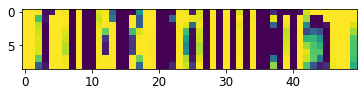

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ntimes = 9 # Consecutive times for the GAN
step = 8  # step between times

scaler_minmax = MinMaxScaler((-1,1))
scaler_reduced = MinMaxScaler((-1,1))

sensor_data_scale = scaler_reduced.fit_transform(sensor_data[:,1:])

# -***************************  Try add noise into the training dataset -***************************#
# Generation of Gaussian noise 
#Gaussian = np.random.normal(0, 1) 
#noise = np.random.normal(0, 0.1, [455,43])
#reduced_sfc = np.add(reduced_sfc,noise)
#print('noise shape',noise.shape)

# ***********************************************************************************************************#
reduced_sfc = np.hstack((reduced_sfc, sensor_data_scale))

def load_Xtrain():
  if (reduced_sfc.shape != (455,50)):
    assert 'check your compressed data from SFC-CAE.'
  X_train_encoded = reduced_sfc
  codings_size = X_train_encoded.shape[1]
  print('coding_size:', codings_size)
  X_train_scaled = scaler_minmax.fit_transform(X_train_encoded)
  print('shape of X_train_scaled: ',X_train_scaled.shape)
  print(np.allclose(X_train_encoded, scaler_minmax.inverse_transform(X_train_scaled)))
  return codings_size, X_train_scaled


def concat_timesteps(X_train, ntimes, step):
  if (len(X_train)!= 455):
    assert 'check your shape of compressed variables.'
  X_train_concat = []
  for i in range(len(X_train) - ntimes*step):
    X_train_concat.append(X_train[i:i+ntimes*step:step])
  return np.array(X_train_concat)


def concat_flatten():
  codings_size, X_train_encoded = load_Xtrain()
  X_train_scaled = X_train_encoded
  X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
  print('X_train_concat: ',X_train_concat.shape)
  X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes)
  plt.imshow(X_train_concat[0, :, :])

  return X_train_concat
  
X_train_concat = concat_flatten()

## Set training dataset for GAN

In [ ]:
# Based on trial and errors with 8, 16, 32, 64, and finally chose 64
BATCH_SIZE = 64

# Based on trial and errors with 10, ncoeffs, 50, 100, and finally chose 100
latent_space = 100

# Create a tensorflow dataset and split it into batches
def grid_search(BATCH_SIZE):
  print('X_train_concat.shape[2]: ',X_train_concat.shape[2])

  train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1).astype('float32')
  print(train_dataset.shape)
  # Creates a Dataset whose elements are slices of the given tensors.
  train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
  # Randomly shuffles the elements of this dataset.
  train_dataset = train_dataset.shuffle(len(X_train_concat))
  # Combines consecutive elements of this dataset into batches.
  train_dataset = train_dataset.batch(BATCH_SIZE)

  return train_dataset

train_dataset = grid_search(BATCH_SIZE)

X_train_concat.shape[2]:  50
(383, 9, 50, 1)


## Useful strategies of training

Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

If n is the number of hidden units in any layer and p is the probability of retaining a unit […] a good dropout net should have at least n/p units: which means that:

A good rule of thumb is to divide the number of nodes in the layer before dropout by the proposed dropout rate and use that as the number of nodes in the new network that uses dropout. For example, a network with 100 nodes and a proposed dropout rate of 0.5 will require 200 nodes (100 / 0.5) when using dropout.

Like other regularization methods, dropout is more effective on those problems where there is a limited amount of training data and the model is likely to overfit the training data.

## LeakyReLU

Leaky version of a Rectified Linear Unit. It allows a small gradient when the unit is not active:

f(x) = alpha * x if x < 0

f(x) = x if x >= 0

default value of alpha in Kerasis 0.3.


In regular ReLU the main drawback is the fact that the input for the activation can be negative, due to operation performed in the network causing to what is referred as "Dying RELU" problem.

## Batch normalisation 

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

So high momentum in BN will result in slow but steady learning (more lag) of the moving mean.

Small batch size => High Momentum (0.9–0.99) <br>
Big batch size => Low Momentum (0.6–0.85)

## The order of activation function and batch normalisation

refer to the discussion in the report.

## Trial and error
refer to txt file in GitHub.

## Model of generator
free to tune by yourself in the code that are commented. 



Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 1800)              180000    
_________________________________________________________________
reshape_22 (Reshape)         (None, 9, 50, 4)          0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 9, 50, 8)          296       
_________________________________________________________________
batch_normalization_44 (Batc (None, 9, 50, 8)          32        
_________________________________________________________________
leaky_re_lu_179 (LeakyReLU)  (None, 9, 50, 8)          0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 9, 50, 4)          292       
_________________________________________________________________
batch_normalization_45 (Batc (None, 9, 50, 4)       

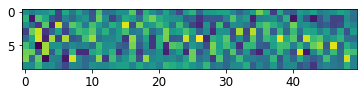

In [ ]:
# strides: An int or list of ints that has length 1,2 or 4. 
joblib.dump(scaler_minmax, "scaler-minmax-sfc824-111.pkl")
# LeayReLU helps with the gradient flow to alleviate probelm of gradient vanish

def make_generator_model():

  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(9*50*4, use_bias=False, input_shape=(latent_space,))) # 2,20,256
  #model.add(keras.layers.LeakyReLU(0.2))
  #model.add(keras.layers.BatchNormalization(momentum=0.85))
  #model.add(keras.layers.ReLU(0.2))
  #model.add(keras.layers.Activation('tanh'))
  #model.add(keras.layers.LeakyReLU(0.8))
  #model.add(keras.layers.ELU())
  #model.add(keras.layers.Dropout(0.1))

  model.add(keras.layers.Reshape((9,50,4))) # 2,20,256

  # out_dim = in_dim * stride = strides * (in_dim - 1) + kernel_size - 2 * padding = 256
  # strides = (a,b): a * A = ntimes, b * B = latent space
  # kernel size = (c,d): 
  #model.add(keras.layers.Conv2DTranspose(8, (3, 3), strides=(1, 1),padding='same', use_bias=False)) 
  model.add(keras.layers.Conv2D(128, kernel_size=3, padding='same'))
  #model.add(keras.layers.LeakyReLU(0.2))
  model.add(keras.layers.BatchNormalization(momentum=0.85))
  #model.add(keras.layers.Activation('tanh'))
  #model.add(keras.layers.ReLU(0.2))
  model.add(keras.layers.LeakyReLU(0.8))
  #model.add(keras.layers.ELU())
  #model.add(keras.layers.Dropout(0.1))

  #model.add(keras.layers.Conv2DTranspose(4, (3, 3), strides=(1, 1), padding='same', output_padding=[0,0],use_bias=False))
  #model.add(keras.layers.LeakyReLU(0.2))
  model.add(keras.layers.Conv2D(64, kernel_size=3, padding='same'))
  model.add(keras.layers.BatchNormalization(momentum=0.85))
  #model.add(keras.layers.Activation('tanh'))
  #model.add(keras.layers.ReLU(0.2))
  model.add(keras.layers.LeakyReLU(0.8))
  #model.add(keras.layers.ELU())
  #model.add(keras.layers.Dropout(0.1))

  #model.add(keras.layers.Conv2DTranspose(32, (3, 3), strides=(1, 1),padding='same', use_bias=False)) 
  ##model.add(keras.layers.LeakyReLU(0.2))
  #model.add(keras.layers.BatchNormalization())
  #model.add(keras.layers.ReLU())
  #model.add(keras.layers.LeakyReLU())
  #model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same',output_padding=[0,0], use_bias=False, activation='tanh')) # sigmoid
  #model.add(keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='tanh'))
  return model

generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, latent_space])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

it’s common to see checkerboard artifacts caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that’s divisible by the stride size whenever we use a strided Conv2DTranpose or Conv2D in both the generator and the discriminator.

A latent vector is randomly generated in order to start the prediction of
time level m-1. The superscript in brackets on the left of the latent vector is the optimisation iteration counter within a time step prediction.

For downsampling, use: Average Pooling or Conv2d + stride

Flattening a tensor means to remove all of the dimensions except for one.

A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor.

## Model of discriminator

In [ ]:
D_input_shape = generated_image.shape[1:]
print(generated_image.shape)
print('D_input size: ',D_input_shape)
print(generated_image.shape[1:])
def make_discriminator_model():

  model = tf.keras.Sequential()
  
  #model.add(keras.layers.Conv2D(128, (2, 2), strides=(1, 2), padding='same',
  #                      input_shape= D_input_shape))
  #model.add(keras.layers.ReLU())
  model.add(keras.layers.Conv2D(32, kernel_size=1, strides=1, padding='same',
                        input_shape= D_input_shape))
  model.add(keras.layers.LeakyReLU(0.8))
  #model.add(keras.layers.Activation('tanh'))
  #model.add(keras.layers.ELU())
  model.add(keras.layers.Dropout(0.3))
 
  #model.add(keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
  model.add(keras.layers.Conv2D(64, kernel_size=1, strides=1, padding='same'))
  ##model.add(keras.layers.ReLU())
  #model.add(keras.layers.LeakyReLU())
  ##model.add(keras.layers.Activation('tanh'))
  ##model.add(keras.layers.ELU())
  #model.add(keras.layers.Dropout(0.3))
 
  #model.add(keras.layers.Conv2D(64, (3, 3), strides=(1, 2), padding='same'))
  #model.add(keras.layers.ReLU())
  model.add(keras.layers.LeakyReLU(0.8))
  #model.add(keras.layers.Activation('tanh'))
  #model.add(keras.layers.ELU())
  model.add(keras.layers.Dropout(0.3))
 
  #model.add(keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
  model.add(keras.layers.Conv2D(128, kernel_size=1, strides=1, padding='same'))
  #model.add(keras.layers.ReLU())
  model.add(keras.layers.LeakyReLU(0.8))
  #model.add(keras.layers.Activation('tanh'))
  #model.add(keras.layers.ELU())
  model.add(keras.layers.Dropout(0.3))
 
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1))

  return model

discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print (decision)

gan = keras.models.Sequential([generator, discriminator])

(1, 9, 50, 1)
D_input size:  (9, 50, 1)
(9, 50, 1)
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_181 (Conv2D)          (None, 9, 50, 32)         64        
_________________________________________________________________
leaky_re_lu_181 (LeakyReLU)  (None, 9, 50, 32)         0         
_________________________________________________________________
dropout_135 (Dropout)        (None, 9, 50, 32)         0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 9, 50, 64)         2112      
_________________________________________________________________
leaky_re_lu_182 (LeakyReLU)  (None, 9, 50, 64)         0         
_________________________________________________________________
dropout_136 (Dropout)        (None, 9, 50, 64)         0         
_________________________________________________________________
c

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [ ]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
#generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.5)
#generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# ******************** hyper-parameter to tune ********************#
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5)
# ******************** *********************** **********************#

# change this as your current file name
notebookName = 'Compression_and_training.ipynb'

# We will reuse this seed overtime 
num_examples_to_generate = 9
seed = tf.random.normal([num_examples_to_generate, latent_space])

# logs to follow losses on tensorboard
generator_log_dir = './logs/' + notebookName[:-6] + '/generator'
discriminator_log_dir = './logs/' + notebookName[:-6] + '/discriminator'

# Creates a summary file writer for the given log directory
generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

@tf.function
def train_step(batch):
  
  # update G twice times than D
  for _ in range(1):
  #for _ in range(4):
    with tf.GradientTape() as gen_tape:
      noise = tf.random.normal([BATCH_SIZE, latent_space])
      generated_images = generator(noise, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
   
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    generator_mean_loss(gen_loss)

  # update D
  with tf.GradientTape() as disc_tape:
    real_output = discriminator(batch, training=True)
    fake_output = discriminator(generated_images, training=True)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  discriminator_mean_loss(disc_loss)

def train(dataset, epochs):
  
  hist = []
  with tf.device('/device:GPU:0'):
    for epoch in range(epochs):
      print("Epoch {}/{}".format(epoch + 1, epochs))
  
      for batch in dataset:
        train_step(batch)
          
      with generator_summary_writer.as_default():
        # Write a scalar summary
        tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)
  
      with discriminator_summary_writer.as_default():
        tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
  
      hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
  
      print("generator loss: ", hist[-1][0]," - ", "discriminator loss: ", hist[-1][1])
  
      # Resets all of the metric state variables.
      # This function is called between epochs/steps, when a metric is evaluated during training.
      generator_mean_loss.reset_states()
      discriminator_mean_loss.reset_states()
  
      # Global variables are used below
      if epoch%10000 == 0: 
        gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
      if epoch%1000 == 0:   
        # plot loss
        print('Loss: ')
        fig, ax = plt.subplots(1,1, figsize=[20,10])
        ax.plot(hist)
        ax.legend(['loss_gen', 'loss_disc'])
        ax.set_yscale('log')
        ax.grid()
        plt.show()
          
  return hist

Epoch 1/30001
generator loss:  0.7037892  -  discriminator loss:  1.2935656
Loss: 


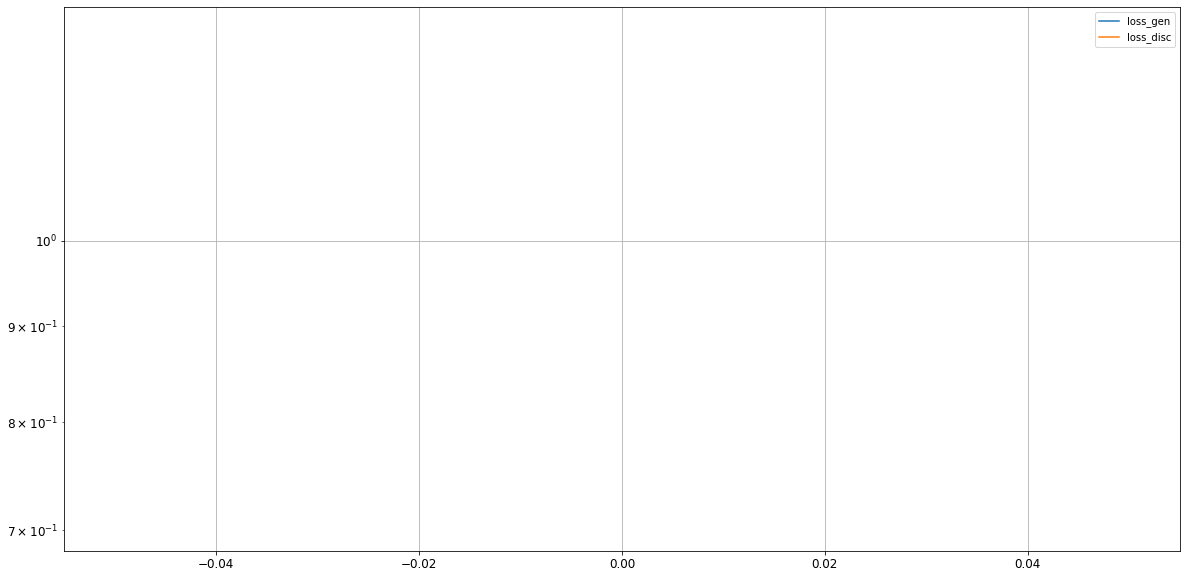

Epoch 2/30001
generator loss:  0.6999081  -  discriminator loss:  1.2076292
Epoch 3/30001
generator loss:  0.7050577  -  discriminator loss:  1.1693677
Epoch 4/30001
generator loss:  0.69276667  -  discriminator loss:  1.1374147
Epoch 5/30001
generator loss:  0.69918364  -  discriminator loss:  1.1104332
Epoch 6/30001
generator loss:  0.69658524  -  discriminator loss:  1.0980155
Epoch 7/30001
generator loss:  0.70164806  -  discriminator loss:  1.0714703
Epoch 8/30001
generator loss:  0.712492  -  discriminator loss:  1.0581425
Epoch 9/30001
generator loss:  0.703288  -  discriminator loss:  1.0420862
Epoch 10/30001
generator loss:  0.7092076  -  discriminator loss:  1.0180453
Epoch 11/30001
generator loss:  0.7199847  -  discriminator loss:  1.0221413
Epoch 12/30001
generator loss:  0.7254565  -  discriminator loss:  1.000298
Epoch 13/30001
generator loss:  0.7266307  -  discriminator loss:  0.99344593
Epoch 14/30001
generator loss:  0.7279468  -  discriminator loss:  0.97830725
Epoc

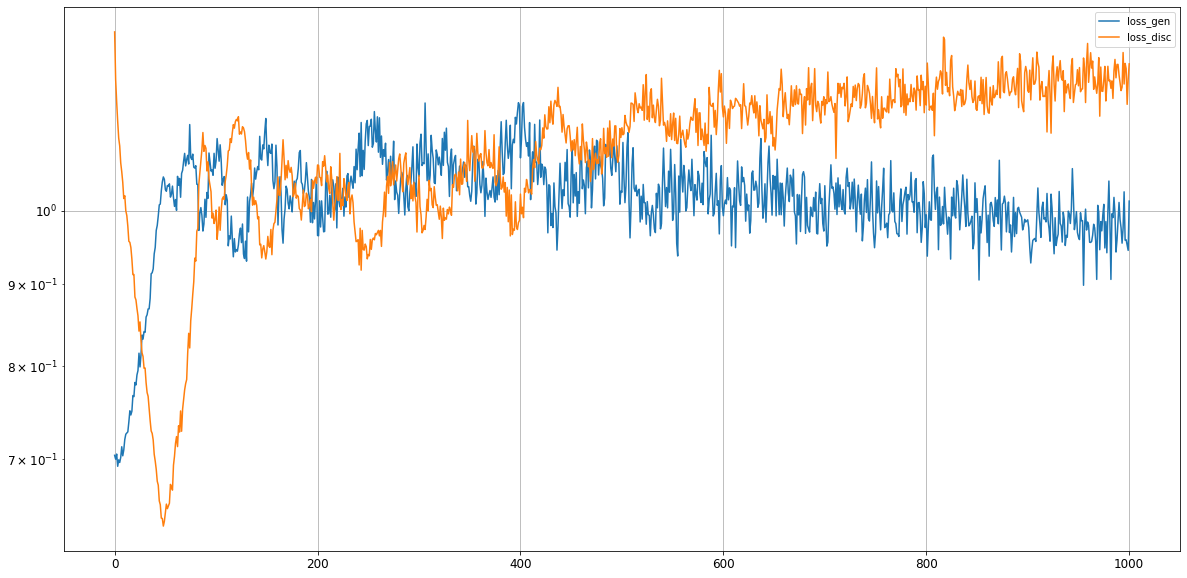

Epoch 1002/30001
generator loss:  0.97617656  -  discriminator loss:  1.2214367
Epoch 1003/30001
generator loss:  0.9409296  -  discriminator loss:  1.2128806
Epoch 1004/30001
generator loss:  0.9687462  -  discriminator loss:  1.2152635
Epoch 1005/30001
generator loss:  0.97213763  -  discriminator loss:  1.1951699
Epoch 1006/30001
generator loss:  0.94681484  -  discriminator loss:  1.2531868
Epoch 1007/30001
generator loss:  0.9321983  -  discriminator loss:  1.1879543
Epoch 1008/30001
generator loss:  0.97200125  -  discriminator loss:  1.2342454
Epoch 1009/30001
generator loss:  0.9409387  -  discriminator loss:  1.2302762
Epoch 1010/30001
generator loss:  0.94706017  -  discriminator loss:  1.2085679
Epoch 1011/30001
generator loss:  0.9750636  -  discriminator loss:  1.2171813
Epoch 1012/30001
generator loss:  0.99842906  -  discriminator loss:  1.2383403
Epoch 1013/30001
generator loss:  1.0001693  -  discriminator loss:  1.2236608
Epoch 1014/30001
generator loss:  0.98372746  

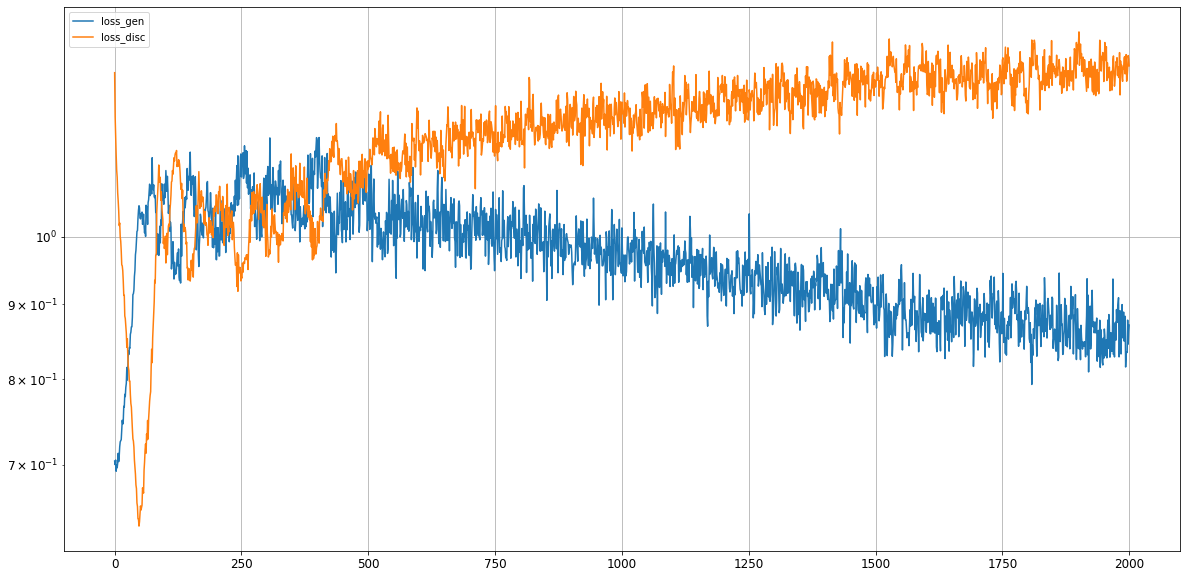

Epoch 2002/30001
generator loss:  0.8590234  -  discriminator loss:  1.3085828
Epoch 2003/30001
generator loss:  0.8998936  -  discriminator loss:  1.2812723
Epoch 2004/30001
generator loss:  0.86556864  -  discriminator loss:  1.3272392
Epoch 2005/30001
generator loss:  0.80231625  -  discriminator loss:  1.3290905
Epoch 2006/30001
generator loss:  0.8848152  -  discriminator loss:  1.3083314
Epoch 2007/30001
generator loss:  0.87530994  -  discriminator loss:  1.2773119
Epoch 2008/30001
generator loss:  0.84104544  -  discriminator loss:  1.3020945
Epoch 2009/30001
generator loss:  0.8609853  -  discriminator loss:  1.3145641
Epoch 2010/30001
generator loss:  0.876055  -  discriminator loss:  1.2729133
Epoch 2011/30001
generator loss:  0.8611972  -  discriminator loss:  1.2848022
Epoch 2012/30001
generator loss:  0.85836935  -  discriminator loss:  1.290772
Epoch 2013/30001
generator loss:  0.9319324  -  discriminator loss:  1.2675526
Epoch 2014/30001
generator loss:  0.87055737  -  

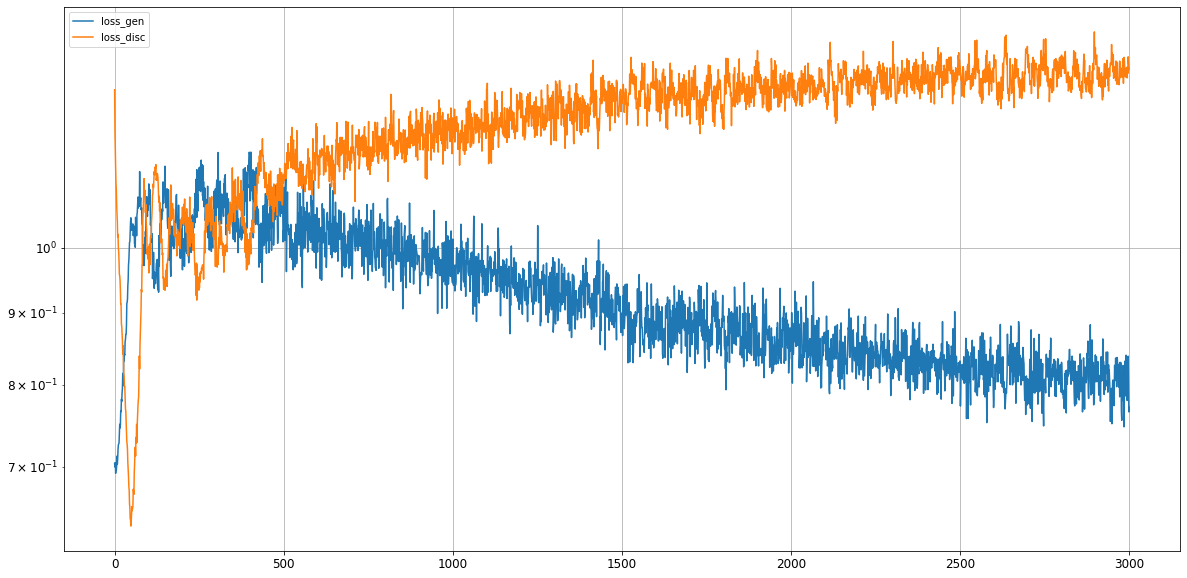

Epoch 3002/30001
generator loss:  0.79274625  -  discriminator loss:  1.3639745
Epoch 3003/30001
generator loss:  0.79065377  -  discriminator loss:  1.3654981
Epoch 3004/30001
generator loss:  0.8031419  -  discriminator loss:  1.3390894
Epoch 3005/30001
generator loss:  0.80422634  -  discriminator loss:  1.3548845
Epoch 3006/30001
generator loss:  0.78508013  -  discriminator loss:  1.3926824
Epoch 3007/30001
generator loss:  0.76128966  -  discriminator loss:  1.3646716
Epoch 3008/30001
generator loss:  0.7472698  -  discriminator loss:  1.3725227
Epoch 3009/30001
generator loss:  0.75806195  -  discriminator loss:  1.3317901
Epoch 3010/30001
generator loss:  0.77410156  -  discriminator loss:  1.3836794
Epoch 3011/30001
generator loss:  0.80714226  -  discriminator loss:  1.3757529
Epoch 3012/30001
generator loss:  0.7894051  -  discriminator loss:  1.369599
Epoch 3013/30001
generator loss:  0.77334577  -  discriminator loss:  1.3645511
Epoch 3014/30001
generator loss:  0.7730065 

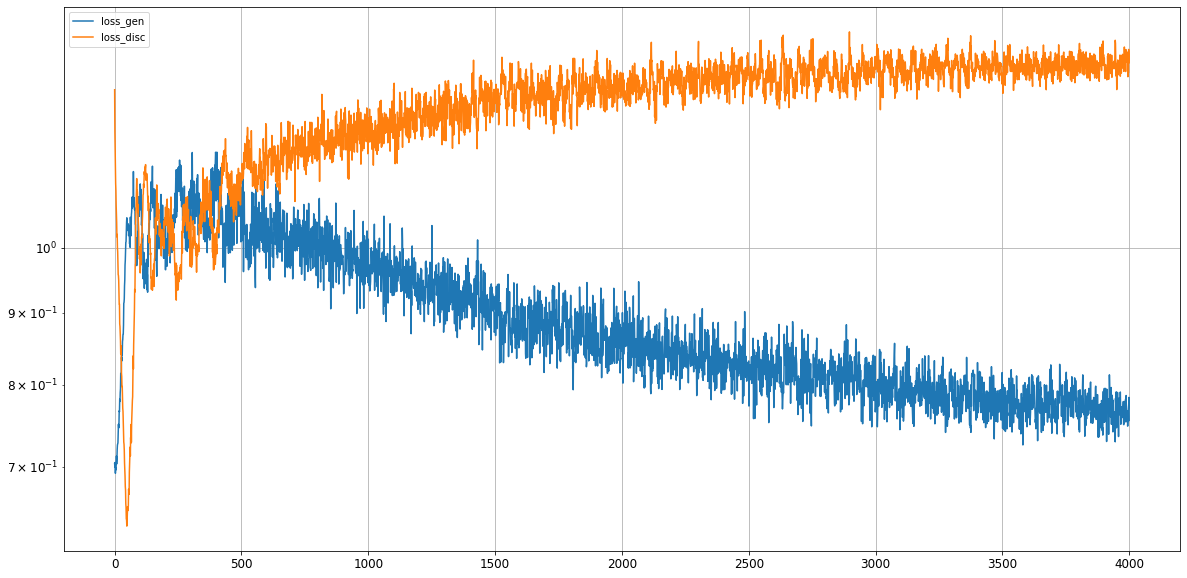

Epoch 4002/30001
generator loss:  0.73897904  -  discriminator loss:  1.3397813
Epoch 4003/30001
generator loss:  0.7337497  -  discriminator loss:  1.3640199
Epoch 4004/30001
generator loss:  0.78275424  -  discriminator loss:  1.353851
Epoch 4005/30001
generator loss:  0.76928896  -  discriminator loss:  1.3695322
Epoch 4006/30001
generator loss:  0.7816809  -  discriminator loss:  1.3449788
Epoch 4007/30001
generator loss:  0.7569328  -  discriminator loss:  1.3466347
Epoch 4008/30001
generator loss:  0.7541919  -  discriminator loss:  1.341534
Epoch 4009/30001
generator loss:  0.768445  -  discriminator loss:  1.3609773
Epoch 4010/30001
generator loss:  0.7515859  -  discriminator loss:  1.3306186
Epoch 4011/30001
generator loss:  0.7748428  -  discriminator loss:  1.3569818
Epoch 4012/30001
generator loss:  0.78036976  -  discriminator loss:  1.3713752
Epoch 4013/30001
generator loss:  0.76875  -  discriminator loss:  1.368838
Epoch 4014/30001
generator loss:  0.7969236  -  discri

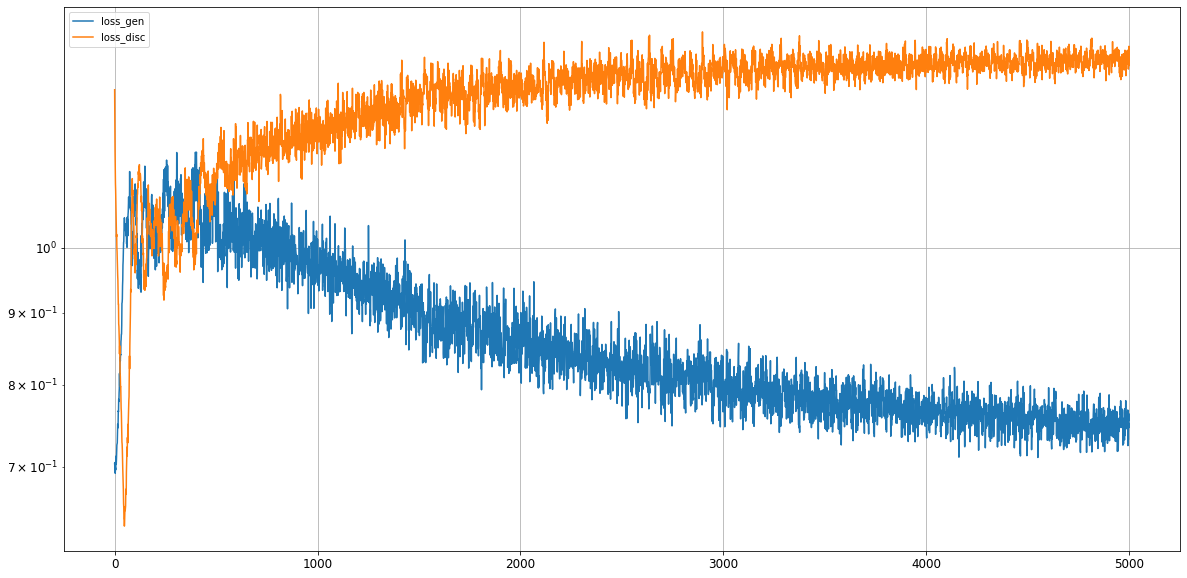

Epoch 5002/30001
generator loss:  0.7284506  -  discriminator loss:  1.3775901
Epoch 5003/30001
generator loss:  0.74673915  -  discriminator loss:  1.3576003
Epoch 5004/30001
generator loss:  0.74717045  -  discriminator loss:  1.3653342
Epoch 5005/30001
generator loss:  0.77602464  -  discriminator loss:  1.3762718
Epoch 5006/30001
generator loss:  0.71711093  -  discriminator loss:  1.3700713
Epoch 5007/30001
generator loss:  0.7453058  -  discriminator loss:  1.3381578
Epoch 5008/30001
generator loss:  0.7505372  -  discriminator loss:  1.3792143
Epoch 5009/30001
generator loss:  0.7658894  -  discriminator loss:  1.347345
Epoch 5010/30001
generator loss:  0.77002263  -  discriminator loss:  1.3422774
Epoch 5011/30001
generator loss:  0.73042613  -  discriminator loss:  1.3586844
Epoch 5012/30001
generator loss:  0.71170115  -  discriminator loss:  1.3377098
Epoch 5013/30001
generator loss:  0.7474835  -  discriminator loss:  1.3281645
Epoch 5014/30001
generator loss:  0.7636938  -

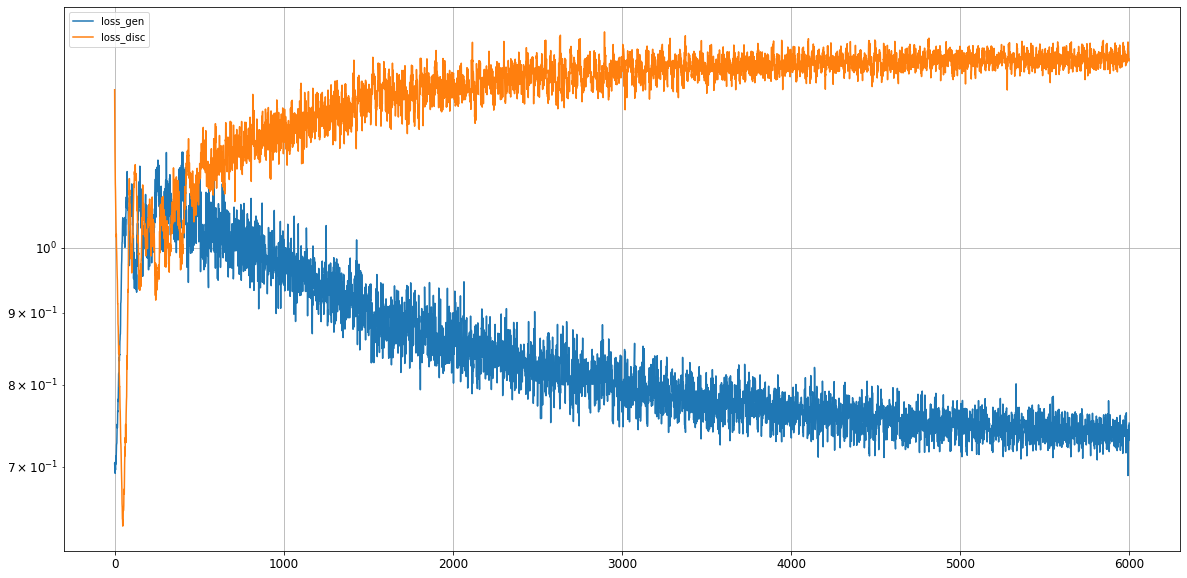

Epoch 6002/30001
generator loss:  0.7524636  -  discriminator loss:  1.3426911
Epoch 6003/30001
generator loss:  0.76506203  -  discriminator loss:  1.3374764
Epoch 6004/30001
generator loss:  0.7649434  -  discriminator loss:  1.3364197
Epoch 6005/30001
generator loss:  0.7437248  -  discriminator loss:  1.3475708
Epoch 6006/30001
generator loss:  0.72828096  -  discriminator loss:  1.3352938
Epoch 6007/30001
generator loss:  0.7411775  -  discriminator loss:  1.3526902
Epoch 6008/30001
generator loss:  0.73840684  -  discriminator loss:  1.3614033
Epoch 6009/30001
generator loss:  0.7332987  -  discriminator loss:  1.3681479
Epoch 6010/30001
generator loss:  0.71314216  -  discriminator loss:  1.3742865
Epoch 6011/30001
generator loss:  0.7575247  -  discriminator loss:  1.3584671
Epoch 6012/30001
generator loss:  0.7260833  -  discriminator loss:  1.3696095
Epoch 6013/30001
generator loss:  0.7293489  -  discriminator loss:  1.3703331
Epoch 6014/30001
generator loss:  0.71152645  - 

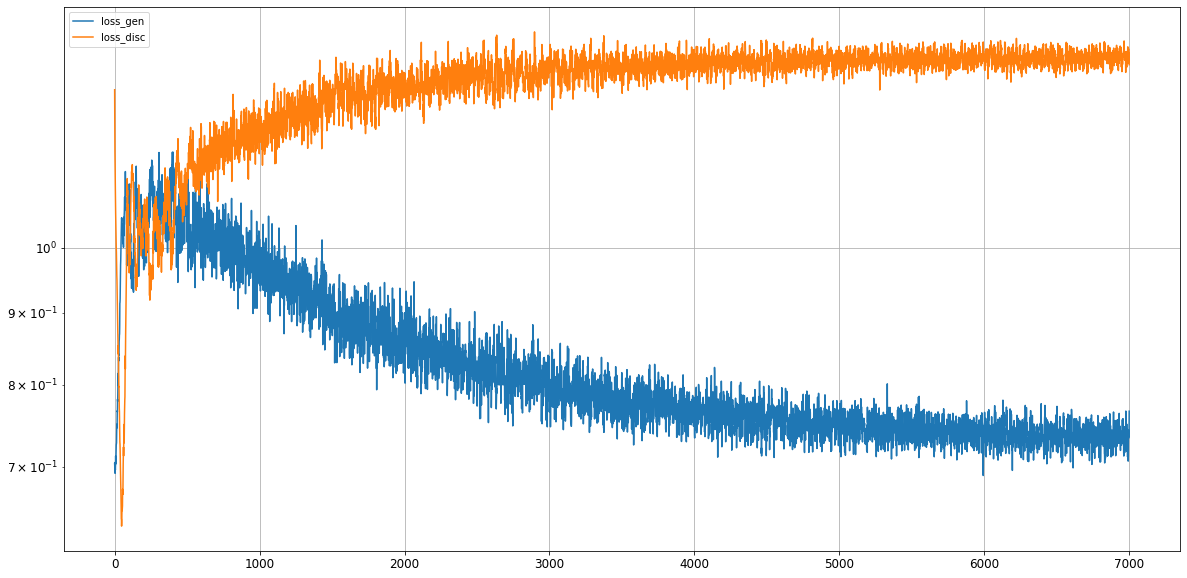

Epoch 7002/30001
generator loss:  0.73932797  -  discriminator loss:  1.3611841
Epoch 7003/30001
generator loss:  0.737215  -  discriminator loss:  1.3534409
Epoch 7004/30001
generator loss:  0.719151  -  discriminator loss:  1.3538351
Epoch 7005/30001
generator loss:  0.73711854  -  discriminator loss:  1.3526754
Epoch 7006/30001
generator loss:  0.74914604  -  discriminator loss:  1.3612112
Epoch 7007/30001
generator loss:  0.7368553  -  discriminator loss:  1.3346047
Epoch 7008/30001
generator loss:  0.74901795  -  discriminator loss:  1.3136576
Epoch 7009/30001
generator loss:  0.73546296  -  discriminator loss:  1.3594157
Epoch 7010/30001
generator loss:  0.71708274  -  discriminator loss:  1.3427849
Epoch 7011/30001
generator loss:  0.7160854  -  discriminator loss:  1.3655499
Epoch 7012/30001
generator loss:  0.72892046  -  discriminator loss:  1.3757969
Epoch 7013/30001
generator loss:  0.7288854  -  discriminator loss:  1.3707279
Epoch 7014/30001
generator loss:  0.73101217  -

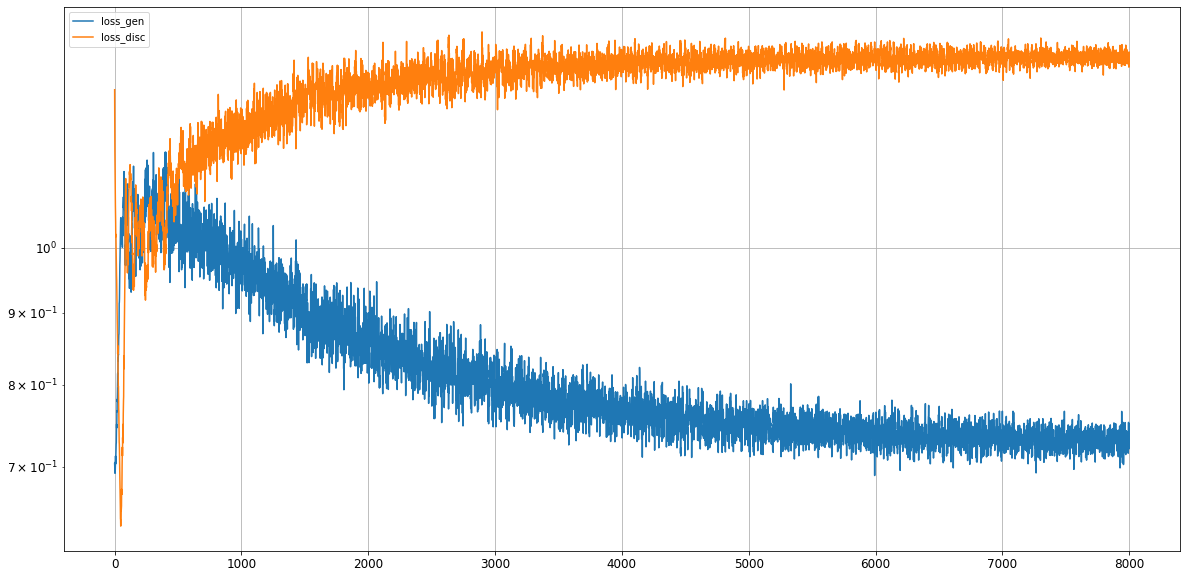

Epoch 8002/30001
generator loss:  0.76534575  -  discriminator loss:  1.3734154
Epoch 8003/30001
generator loss:  0.75004417  -  discriminator loss:  1.3517084
Epoch 8004/30001
generator loss:  0.7455673  -  discriminator loss:  1.366846
Epoch 8005/30001
generator loss:  0.733174  -  discriminator loss:  1.3681616
Epoch 8006/30001
generator loss:  0.7122545  -  discriminator loss:  1.3565993
Epoch 8007/30001
generator loss:  0.7151175  -  discriminator loss:  1.3506275
Epoch 8008/30001
generator loss:  0.7162781  -  discriminator loss:  1.3892676
Epoch 8009/30001
generator loss:  0.7442246  -  discriminator loss:  1.3452371
Epoch 8010/30001
generator loss:  0.7258813  -  discriminator loss:  1.3665195
Epoch 8011/30001
generator loss:  0.70507365  -  discriminator loss:  1.36311
Epoch 8012/30001
generator loss:  0.716995  -  discriminator loss:  1.3631325
Epoch 8013/30001
generator loss:  0.7312312  -  discriminator loss:  1.3651633
Epoch 8014/30001
generator loss:  0.71214014  -  discr

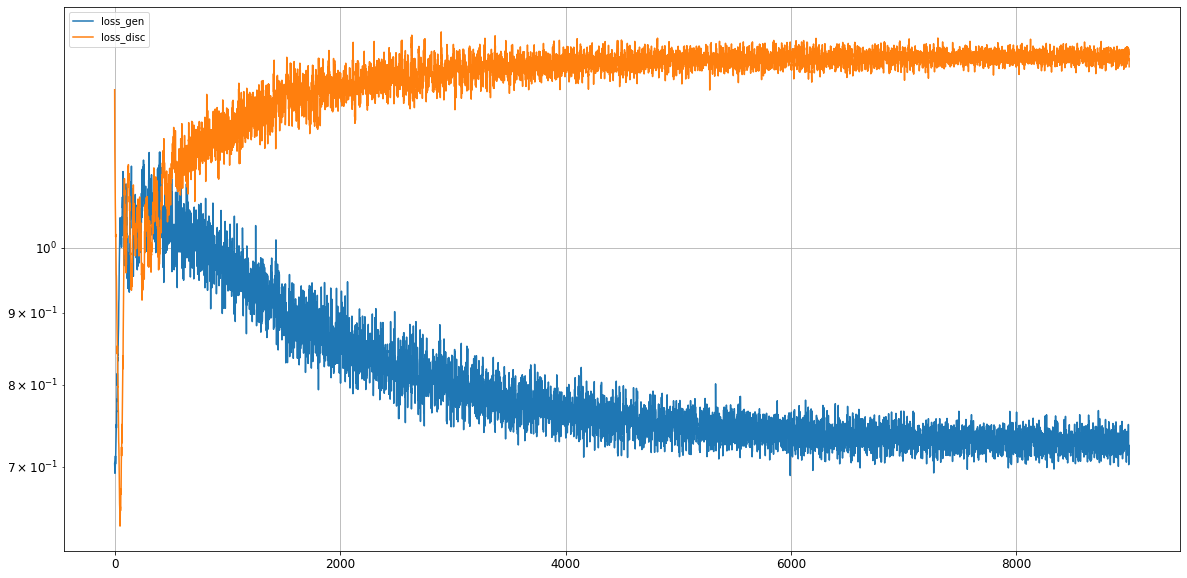

Epoch 9002/30001
generator loss:  0.74761385  -  discriminator loss:  1.3786687
Epoch 9003/30001
generator loss:  0.7519348  -  discriminator loss:  1.359682
Epoch 9004/30001
generator loss:  0.7283022  -  discriminator loss:  1.3615693
Epoch 9005/30001
generator loss:  0.7396164  -  discriminator loss:  1.3614239
Epoch 9006/30001
generator loss:  0.7394474  -  discriminator loss:  1.3529528
Epoch 9007/30001
generator loss:  0.719294  -  discriminator loss:  1.360623
Epoch 9008/30001
generator loss:  0.72471833  -  discriminator loss:  1.3732063
Epoch 9009/30001
generator loss:  0.7274256  -  discriminator loss:  1.3738676
Epoch 9010/30001
generator loss:  0.7285585  -  discriminator loss:  1.3543625
Epoch 9011/30001
generator loss:  0.7262202  -  discriminator loss:  1.3852011
Epoch 9012/30001
generator loss:  0.7212407  -  discriminator loss:  1.3655077
Epoch 9013/30001
generator loss:  0.73377126  -  discriminator loss:  1.393392
Epoch 9014/30001
generator loss:  0.72704095  -  disc

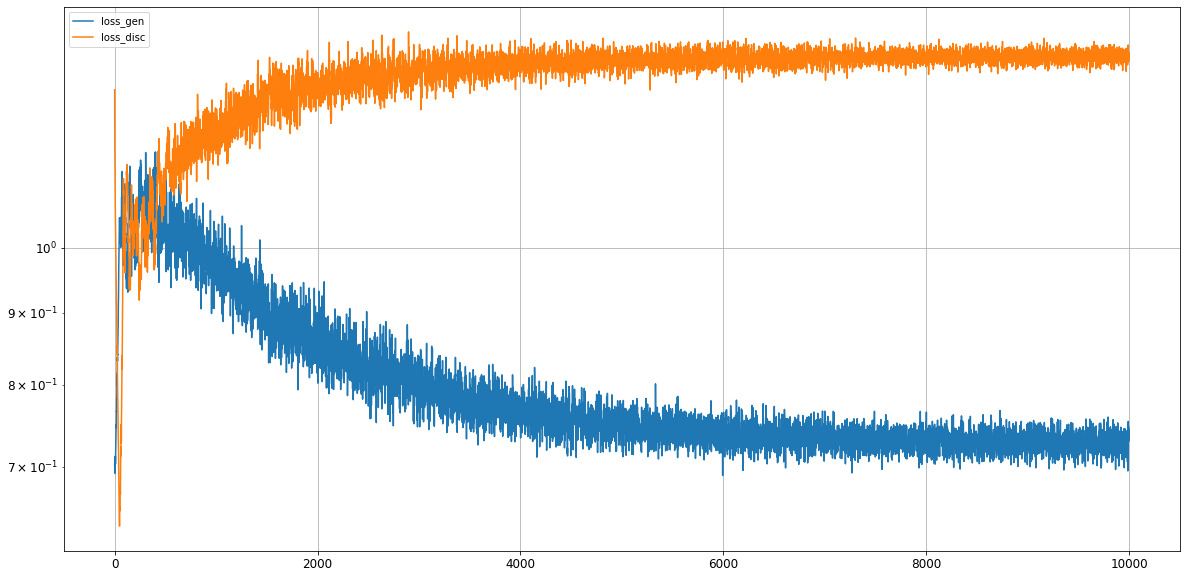

Epoch 10002/30001
generator loss:  0.7295983  -  discriminator loss:  1.3814067
Epoch 10003/30001
generator loss:  0.7166946  -  discriminator loss:  1.3756634
Epoch 10004/30001
generator loss:  0.71174914  -  discriminator loss:  1.3679104
Epoch 10005/30001
generator loss:  0.71951866  -  discriminator loss:  1.3677381
Epoch 10006/30001
generator loss:  0.7141847  -  discriminator loss:  1.3519344
Epoch 10007/30001
generator loss:  0.7018873  -  discriminator loss:  1.355477
Epoch 10008/30001
generator loss:  0.72470564  -  discriminator loss:  1.3500772
Epoch 10009/30001
generator loss:  0.71375775  -  discriminator loss:  1.367485
Epoch 10010/30001
generator loss:  0.71934986  -  discriminator loss:  1.3666812
Epoch 10011/30001
generator loss:  0.73459953  -  discriminator loss:  1.3642263
Epoch 10012/30001
generator loss:  0.72771883  -  discriminator loss:  1.3633051
Epoch 10013/30001
generator loss:  0.7264187  -  discriminator loss:  1.3742727
Epoch 10014/30001
generator loss:  

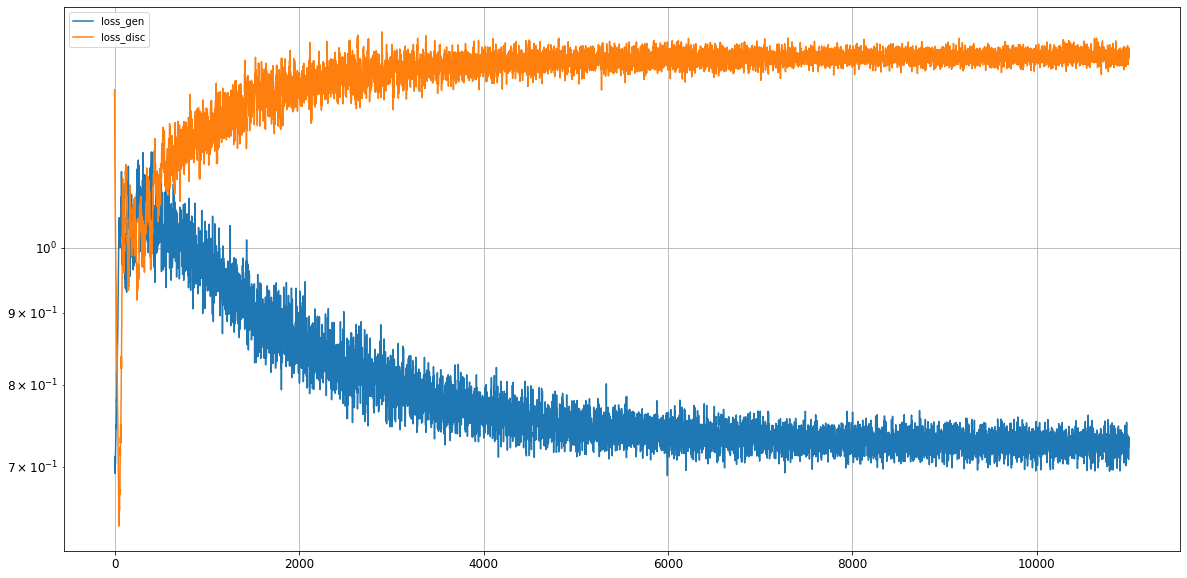

Epoch 11002/30001
generator loss:  0.71686524  -  discriminator loss:  1.384006
Epoch 11003/30001
generator loss:  0.70710856  -  discriminator loss:  1.3812777
Epoch 11004/30001
generator loss:  0.7106988  -  discriminator loss:  1.3737289
Epoch 11005/30001
generator loss:  0.7129844  -  discriminator loss:  1.3798653
Epoch 11006/30001
generator loss:  0.7342189  -  discriminator loss:  1.3705565
Epoch 11007/30001
generator loss:  0.7271085  -  discriminator loss:  1.3872982
Epoch 11008/30001
generator loss:  0.73379785  -  discriminator loss:  1.3591837
Epoch 11009/30001
generator loss:  0.72202367  -  discriminator loss:  1.3701316
Epoch 11010/30001
generator loss:  0.7203401  -  discriminator loss:  1.3545538
Epoch 11011/30001
generator loss:  0.7327406  -  discriminator loss:  1.3612274
Epoch 11012/30001
generator loss:  0.73058414  -  discriminator loss:  1.3745799
Epoch 11013/30001
generator loss:  0.73128635  -  discriminator loss:  1.3689928
Epoch 11014/30001
generator loss:  

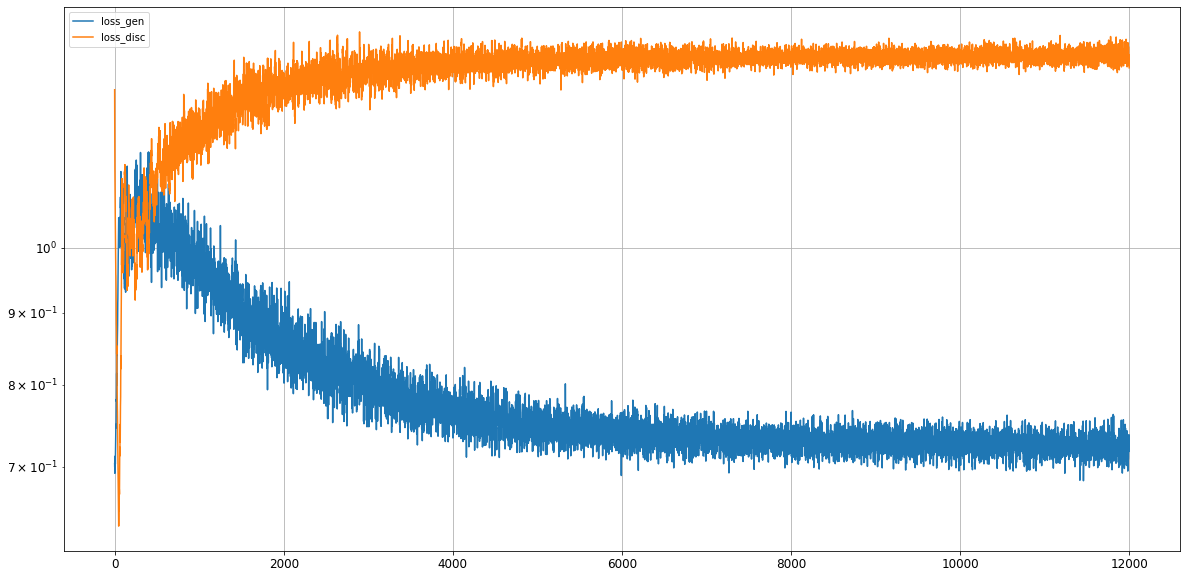

Epoch 12002/30001
generator loss:  0.7217843  -  discriminator loss:  1.3662992
Epoch 12003/30001
generator loss:  0.727813  -  discriminator loss:  1.3672667
Epoch 12004/30001
generator loss:  0.7299666  -  discriminator loss:  1.3415502
Epoch 12005/30001
generator loss:  0.7368316  -  discriminator loss:  1.3323196
Epoch 12006/30001
generator loss:  0.7214854  -  discriminator loss:  1.3572626
Epoch 12007/30001
generator loss:  0.7269218  -  discriminator loss:  1.3591633
Epoch 12008/30001
generator loss:  0.7257857  -  discriminator loss:  1.3499371
Epoch 12009/30001
generator loss:  0.7162244  -  discriminator loss:  1.3600248
Epoch 12010/30001
generator loss:  0.7290063  -  discriminator loss:  1.3409752
Epoch 12011/30001
generator loss:  0.71763325  -  discriminator loss:  1.3692008
Epoch 12012/30001
generator loss:  0.7174907  -  discriminator loss:  1.3609204
Epoch 12013/30001
generator loss:  0.73030394  -  discriminator loss:  1.3682809
Epoch 12014/30001
generator loss:  0.71

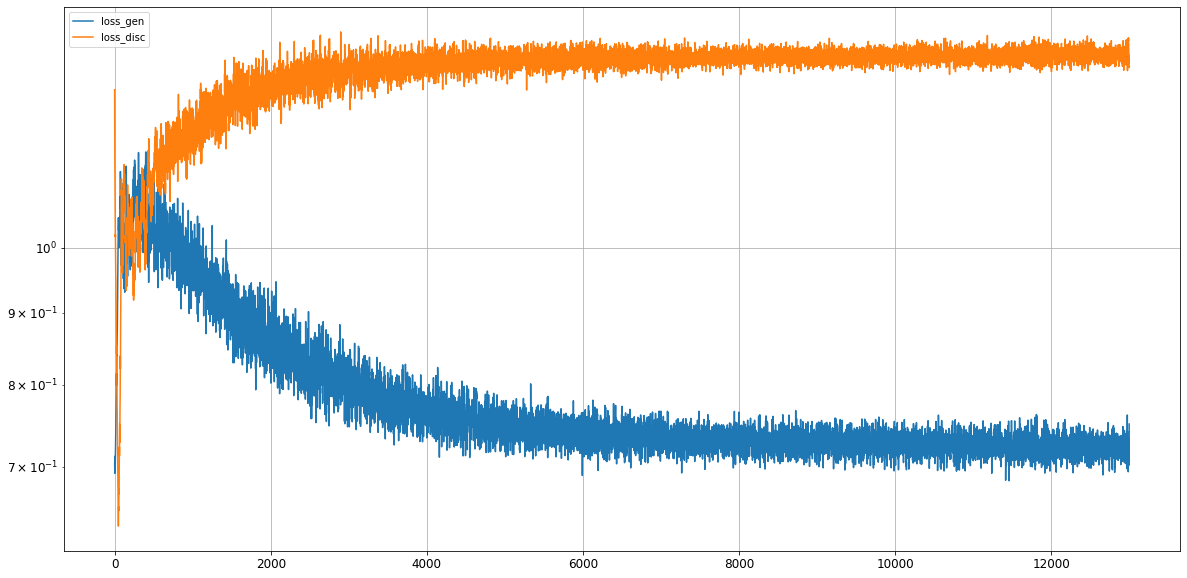

Epoch 13002/30001
generator loss:  0.7281764  -  discriminator loss:  1.3608218
Epoch 13003/30001
generator loss:  0.7166033  -  discriminator loss:  1.3471695
Epoch 13004/30001
generator loss:  0.71097946  -  discriminator loss:  1.3385903
Epoch 13005/30001
generator loss:  0.7329461  -  discriminator loss:  1.3585545
Epoch 13006/30001
generator loss:  0.7090805  -  discriminator loss:  1.3717338
Epoch 13007/30001
generator loss:  0.7120631  -  discriminator loss:  1.3645682
Epoch 13008/30001
generator loss:  0.6918151  -  discriminator loss:  1.3665925
Epoch 13009/30001
generator loss:  0.70122576  -  discriminator loss:  1.3775806
Epoch 13010/30001
generator loss:  0.7014304  -  discriminator loss:  1.3876401
Epoch 13011/30001
generator loss:  0.7045305  -  discriminator loss:  1.3902885
Epoch 13012/30001
generator loss:  0.71360445  -  discriminator loss:  1.3885255
Epoch 13013/30001
generator loss:  0.71917254  -  discriminator loss:  1.3972403
Epoch 13014/30001
generator loss:  0

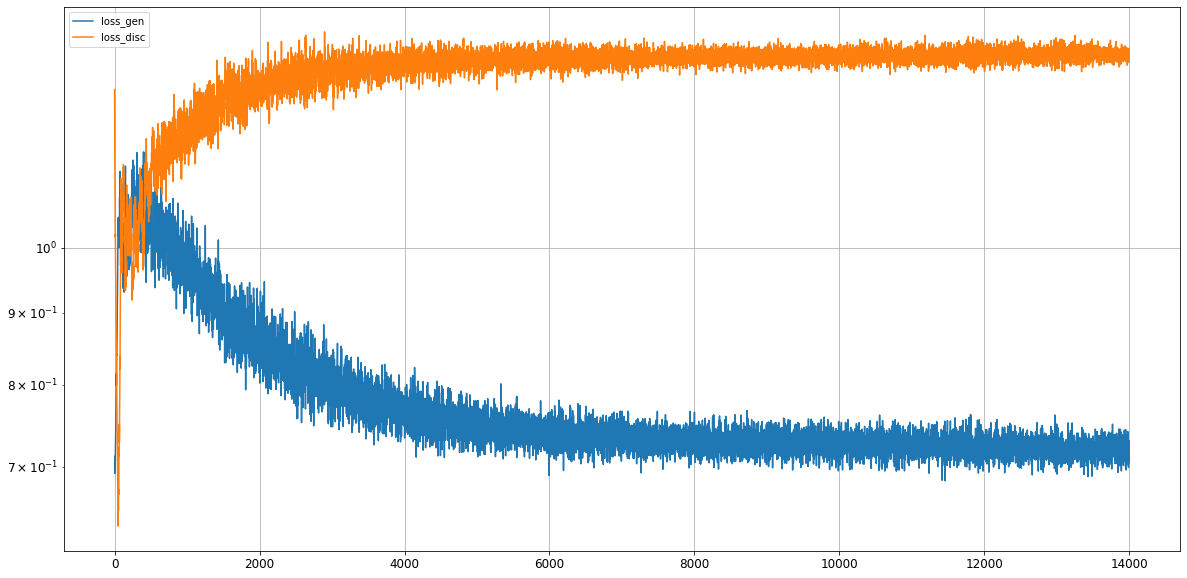

Epoch 14002/30001
generator loss:  0.73082185  -  discriminator loss:  1.3713278
Epoch 14003/30001
generator loss:  0.71169496  -  discriminator loss:  1.3745484
Epoch 14004/30001
generator loss:  0.70198935  -  discriminator loss:  1.3601394
Epoch 14005/30001
generator loss:  0.71770185  -  discriminator loss:  1.3569623
Epoch 14006/30001
generator loss:  0.7343952  -  discriminator loss:  1.3721274
Epoch 14007/30001
generator loss:  0.7281594  -  discriminator loss:  1.3516512
Epoch 14008/30001
generator loss:  0.7154382  -  discriminator loss:  1.3617035
Epoch 14009/30001
generator loss:  0.7009962  -  discriminator loss:  1.3627902
Epoch 14010/30001
generator loss:  0.7245639  -  discriminator loss:  1.3785099
Epoch 14011/30001
generator loss:  0.71787876  -  discriminator loss:  1.3670446
Epoch 14012/30001
generator loss:  0.7201349  -  discriminator loss:  1.3531942
Epoch 14013/30001
generator loss:  0.7221842  -  discriminator loss:  1.3746176
Epoch 14014/30001
generator loss:  

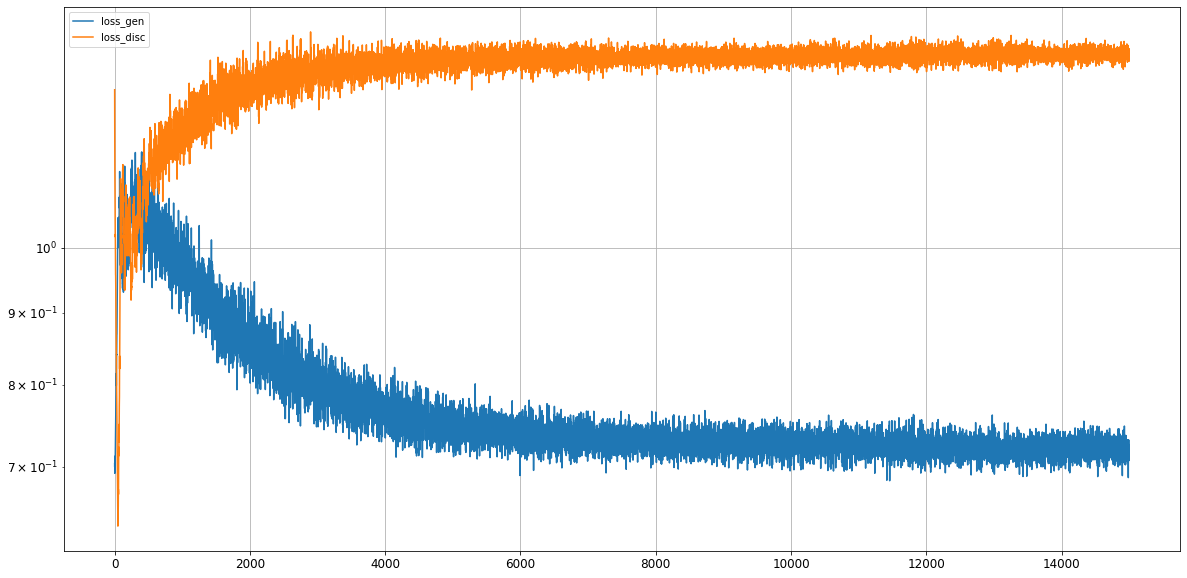

Epoch 15002/30001
generator loss:  0.73263925  -  discriminator loss:  1.3596225
Epoch 15003/30001
generator loss:  0.720957  -  discriminator loss:  1.3732481
Epoch 15004/30001
generator loss:  0.71935767  -  discriminator loss:  1.3585218
Epoch 15005/30001
generator loss:  0.7155242  -  discriminator loss:  1.3853663
Epoch 15006/30001
generator loss:  0.7287038  -  discriminator loss:  1.3769685
Epoch 15007/30001
generator loss:  0.7248473  -  discriminator loss:  1.3840603
Epoch 15008/30001
generator loss:  0.7282147  -  discriminator loss:  1.3797675
Epoch 15009/30001
generator loss:  0.7167198  -  discriminator loss:  1.3810557
Epoch 15010/30001
generator loss:  0.71263003  -  discriminator loss:  1.3930588
Epoch 15011/30001
generator loss:  0.69431216  -  discriminator loss:  1.3991518
Epoch 15012/30001
generator loss:  0.73391914  -  discriminator loss:  1.3788134
Epoch 15013/30001
generator loss:  0.70996696  -  discriminator loss:  1.3729562
Epoch 15014/30001
generator loss:  

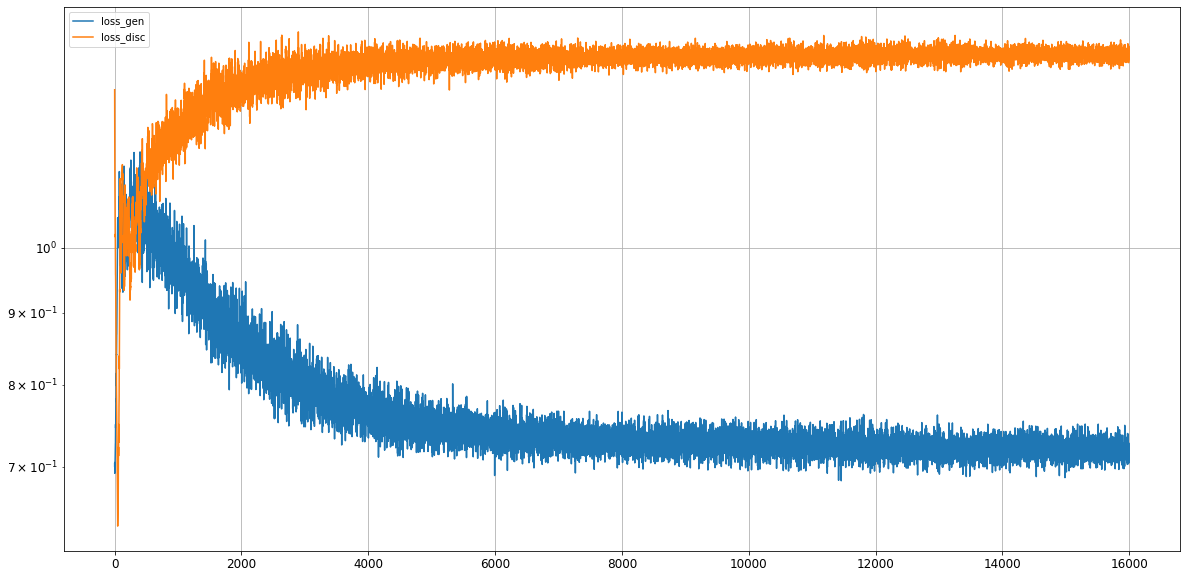

Epoch 16002/30001
generator loss:  0.7231078  -  discriminator loss:  1.3701493
Epoch 16003/30001
generator loss:  0.72612435  -  discriminator loss:  1.3893871
Epoch 16004/30001
generator loss:  0.71823066  -  discriminator loss:  1.372582
Epoch 16005/30001
generator loss:  0.7203978  -  discriminator loss:  1.3789668
Epoch 16006/30001
generator loss:  0.72640324  -  discriminator loss:  1.3548335
Epoch 16007/30001
generator loss:  0.7345457  -  discriminator loss:  1.3848482
Epoch 16008/30001
generator loss:  0.7131817  -  discriminator loss:  1.3649324
Epoch 16009/30001
generator loss:  0.70200425  -  discriminator loss:  1.3651652
Epoch 16010/30001
generator loss:  0.71404344  -  discriminator loss:  1.3689866
Epoch 16011/30001
generator loss:  0.72144884  -  discriminator loss:  1.3682901
Epoch 16012/30001
generator loss:  0.73408276  -  discriminator loss:  1.3497971
Epoch 16013/30001
generator loss:  0.7150337  -  discriminator loss:  1.3638544
Epoch 16014/30001
generator loss: 

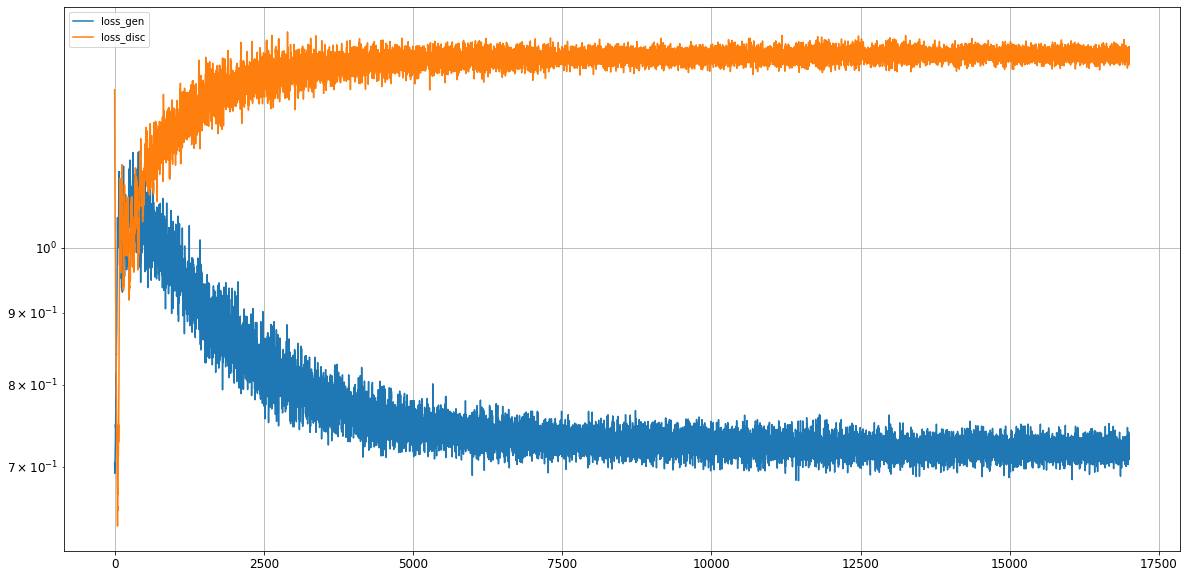

Epoch 17002/30001
generator loss:  0.7122155  -  discriminator loss:  1.3682202
Epoch 17003/30001
generator loss:  0.6994653  -  discriminator loss:  1.3648845
Epoch 17004/30001
generator loss:  0.710535  -  discriminator loss:  1.3830205
Epoch 17005/30001
generator loss:  0.73565125  -  discriminator loss:  1.3837904
Epoch 17006/30001
generator loss:  0.7201231  -  discriminator loss:  1.3686355
Epoch 17007/30001
generator loss:  0.7332229  -  discriminator loss:  1.3664454
Epoch 17008/30001
generator loss:  0.7166576  -  discriminator loss:  1.3568412
Epoch 17009/30001
generator loss:  0.7305462  -  discriminator loss:  1.3661982
Epoch 17010/30001
generator loss:  0.738358  -  discriminator loss:  1.3785677
Epoch 17011/30001
generator loss:  0.7332151  -  discriminator loss:  1.3502173
Epoch 17012/30001
generator loss:  0.73228574  -  discriminator loss:  1.3696927
Epoch 17013/30001
generator loss:  0.72856647  -  discriminator loss:  1.3489672
Epoch 17014/30001
generator loss:  0.74

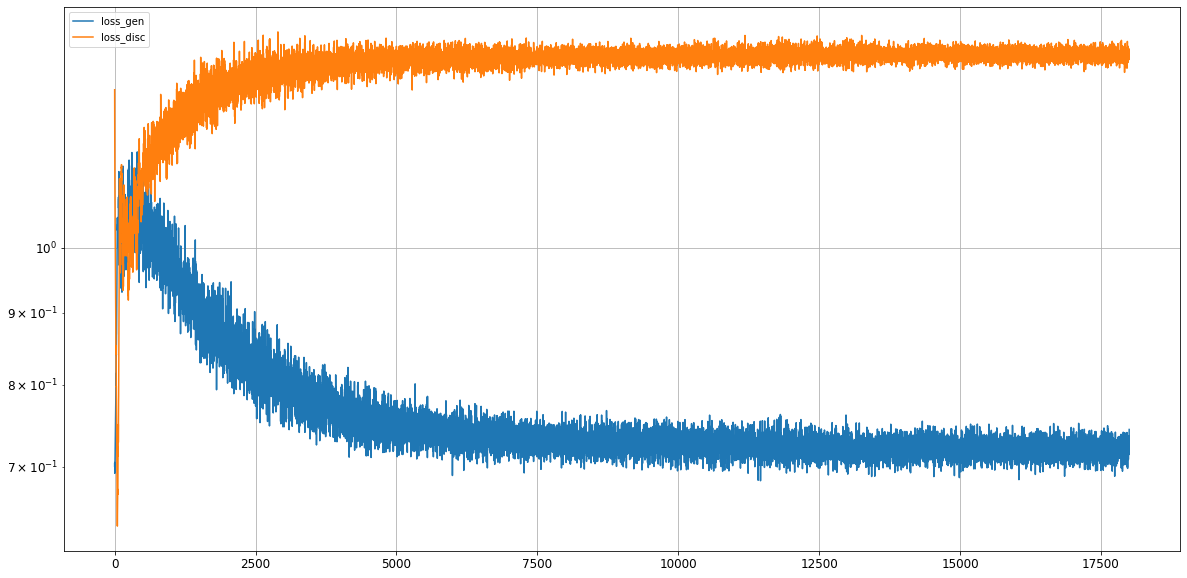

Epoch 18002/30001
generator loss:  0.7330635  -  discriminator loss:  1.3608689
Epoch 18003/30001
generator loss:  0.72473663  -  discriminator loss:  1.3458519
Epoch 18004/30001
generator loss:  0.70661515  -  discriminator loss:  1.3635529
Epoch 18005/30001
generator loss:  0.71390146  -  discriminator loss:  1.378081
Epoch 18006/30001
generator loss:  0.7113817  -  discriminator loss:  1.3546041
Epoch 18007/30001
generator loss:  0.7115333  -  discriminator loss:  1.3907353
Epoch 18008/30001
generator loss:  0.70241326  -  discriminator loss:  1.3654242
Epoch 18009/30001
generator loss:  0.7100565  -  discriminator loss:  1.3831577
Epoch 18010/30001
generator loss:  0.7139663  -  discriminator loss:  1.3884672
Epoch 18011/30001
generator loss:  0.7138932  -  discriminator loss:  1.3917131
Epoch 18012/30001
generator loss:  0.7149424  -  discriminator loss:  1.3673083
Epoch 18013/30001
generator loss:  0.7262345  -  discriminator loss:  1.3747753
Epoch 18014/30001
generator loss:  0.

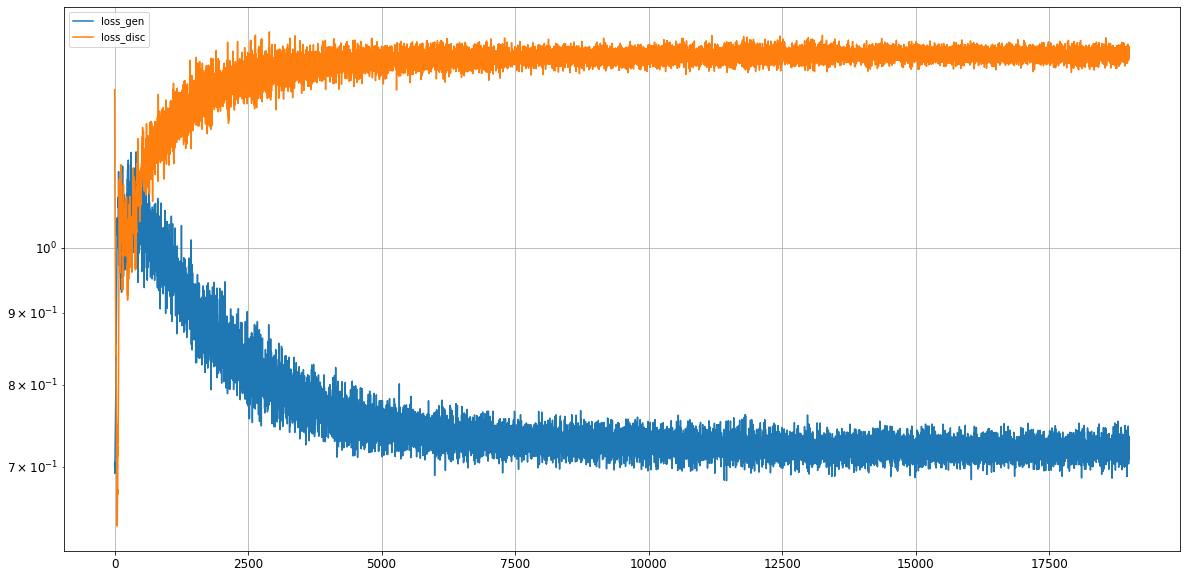

Epoch 19002/30001
generator loss:  0.7422555  -  discriminator loss:  1.3734993
Epoch 19003/30001
generator loss:  0.748749  -  discriminator loss:  1.3588558
Epoch 19004/30001
generator loss:  0.7350366  -  discriminator loss:  1.344644
Epoch 19005/30001
generator loss:  0.72658414  -  discriminator loss:  1.3599977
Epoch 19006/30001
generator loss:  0.7238793  -  discriminator loss:  1.3686575
Epoch 19007/30001
generator loss:  0.72765845  -  discriminator loss:  1.3460327
Epoch 19008/30001
generator loss:  0.7158828  -  discriminator loss:  1.3496324
Epoch 19009/30001
generator loss:  0.7212095  -  discriminator loss:  1.3723053
Epoch 19010/30001
generator loss:  0.7187605  -  discriminator loss:  1.3801357
Epoch 19011/30001
generator loss:  0.7150516  -  discriminator loss:  1.381725
Epoch 19012/30001
generator loss:  0.70976514  -  discriminator loss:  1.3873405
Epoch 19013/30001
generator loss:  0.723393  -  discriminator loss:  1.3623158
Epoch 19014/30001
generator loss:  0.7248

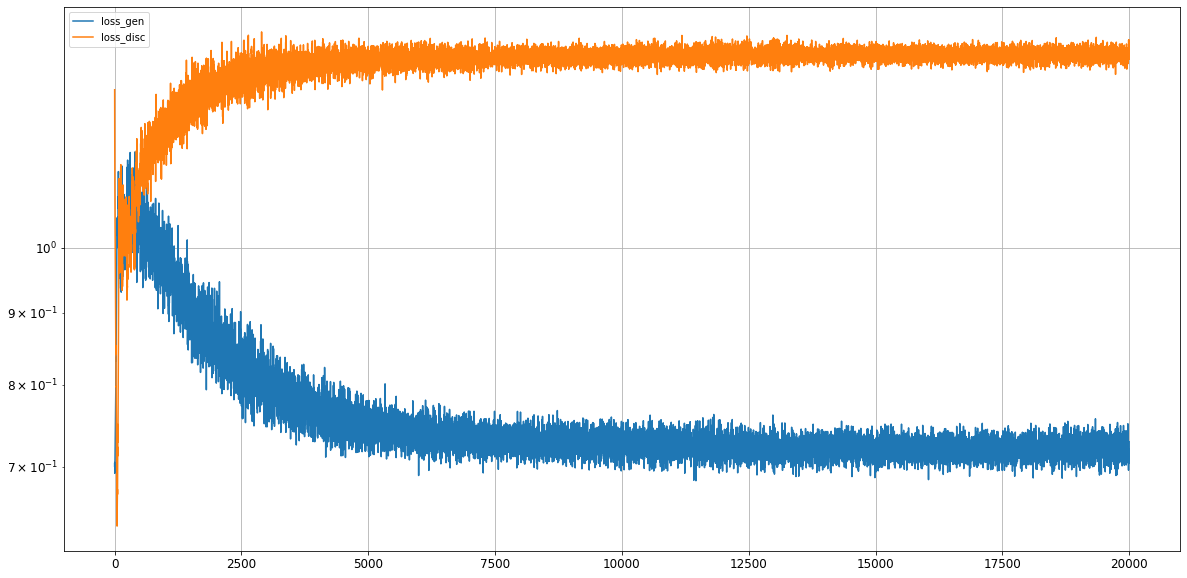

Epoch 20002/30001
generator loss:  0.7340428  -  discriminator loss:  1.3581219
Epoch 20003/30001
generator loss:  0.73245615  -  discriminator loss:  1.352214
Epoch 20004/30001
generator loss:  0.7267476  -  discriminator loss:  1.364262
Epoch 20005/30001
generator loss:  0.7255632  -  discriminator loss:  1.3625876
Epoch 20006/30001
generator loss:  0.7170647  -  discriminator loss:  1.3575405
Epoch 20007/30001
generator loss:  0.7107396  -  discriminator loss:  1.367229
Epoch 20008/30001
generator loss:  0.7228152  -  discriminator loss:  1.3706841
Epoch 20009/30001
generator loss:  0.72982794  -  discriminator loss:  1.3701363
Epoch 20010/30001
generator loss:  0.71818495  -  discriminator loss:  1.3628229
Epoch 20011/30001
generator loss:  0.7169648  -  discriminator loss:  1.3879699
Epoch 20012/30001
generator loss:  0.72014946  -  discriminator loss:  1.380858
Epoch 20013/30001
generator loss:  0.7147505  -  discriminator loss:  1.3860698
Epoch 20014/30001
generator loss:  0.709

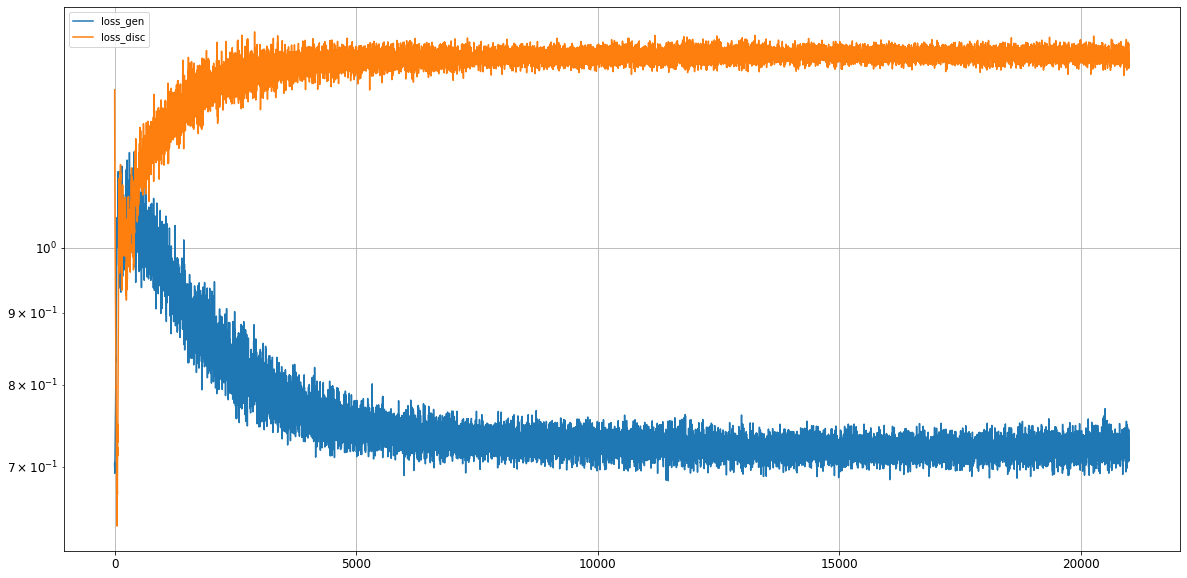

Epoch 21002/30001
generator loss:  0.7115681  -  discriminator loss:  1.3471718
Epoch 21003/30001
generator loss:  0.70927304  -  discriminator loss:  1.3701516
Epoch 21004/30001
generator loss:  0.72528833  -  discriminator loss:  1.3521763
Epoch 21005/30001
generator loss:  0.72941405  -  discriminator loss:  1.3604641
Epoch 21006/30001
generator loss:  0.7298972  -  discriminator loss:  1.3623797
Epoch 21007/30001
generator loss:  0.7191308  -  discriminator loss:  1.387145
Epoch 21008/30001
generator loss:  0.7193622  -  discriminator loss:  1.3655325
Epoch 21009/30001
generator loss:  0.71164125  -  discriminator loss:  1.3454672
Epoch 21010/30001
generator loss:  0.74200183  -  discriminator loss:  1.3771645
Epoch 21011/30001
generator loss:  0.7444803  -  discriminator loss:  1.3600988
Epoch 21012/30001
generator loss:  0.7404701  -  discriminator loss:  1.3584785
Epoch 21013/30001
generator loss:  0.74200016  -  discriminator loss:  1.3682362
Epoch 21014/30001
generator loss:  

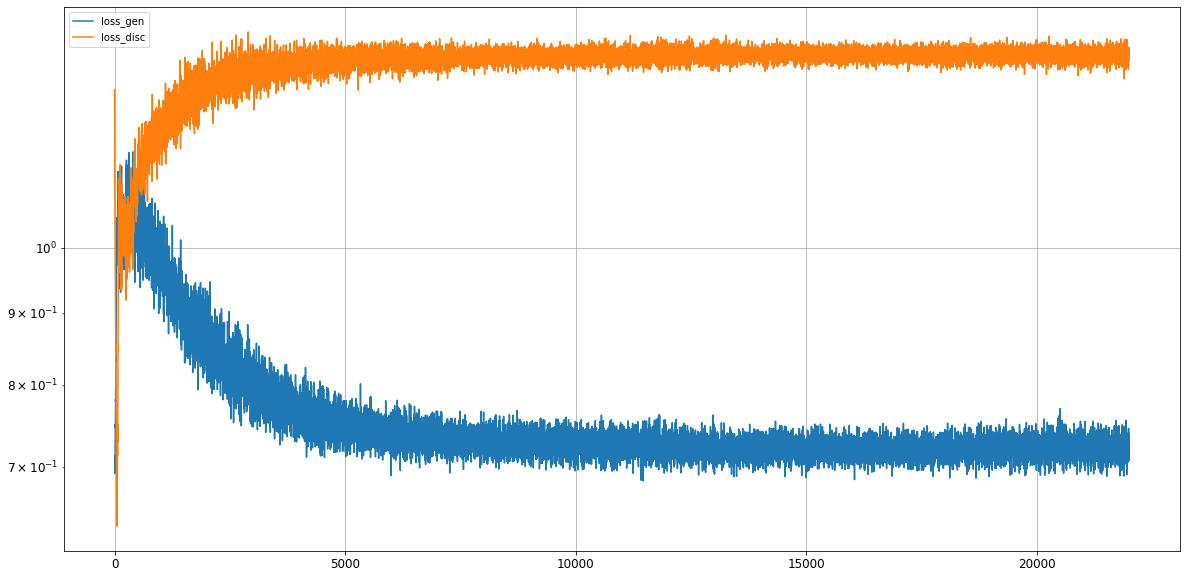

Epoch 22002/30001
generator loss:  0.7328759  -  discriminator loss:  1.3772322
Epoch 22003/30001
generator loss:  0.72437865  -  discriminator loss:  1.386762
Epoch 22004/30001
generator loss:  0.72739196  -  discriminator loss:  1.3677834
Epoch 22005/30001
generator loss:  0.708272  -  discriminator loss:  1.3650047
Epoch 22006/30001
generator loss:  0.71572596  -  discriminator loss:  1.3743806
Epoch 22007/30001
generator loss:  0.72646886  -  discriminator loss:  1.3829342
Epoch 22008/30001
generator loss:  0.7440655  -  discriminator loss:  1.3633052
Epoch 22009/30001
generator loss:  0.7201175  -  discriminator loss:  1.354478
Epoch 22010/30001
generator loss:  0.7235432  -  discriminator loss:  1.3817801
Epoch 22011/30001
generator loss:  0.7187548  -  discriminator loss:  1.3728414
Epoch 22012/30001
generator loss:  0.71640664  -  discriminator loss:  1.3749086
Epoch 22013/30001
generator loss:  0.72001487  -  discriminator loss:  1.3661734
Epoch 22014/30001
generator loss:  0.

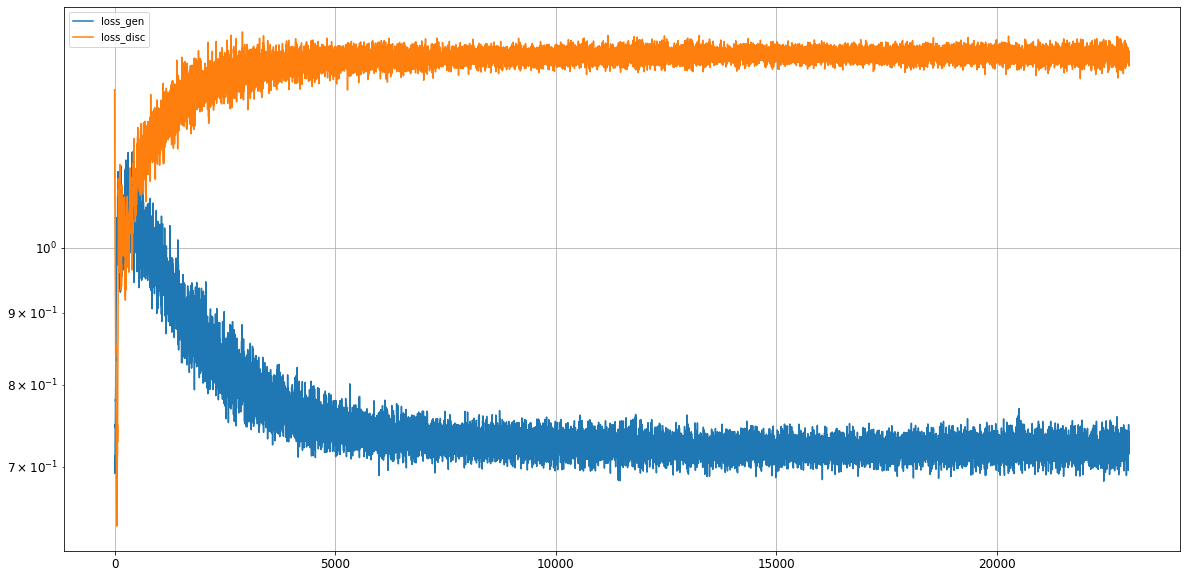

Epoch 23002/30001
generator loss:  0.72876877  -  discriminator loss:  1.381051
Epoch 23003/30001
generator loss:  0.71830845  -  discriminator loss:  1.3873391
Epoch 23004/30001
generator loss:  0.7105624  -  discriminator loss:  1.3753247
Epoch 23005/30001
generator loss:  0.71754646  -  discriminator loss:  1.3856316
Epoch 23006/30001
generator loss:  0.7397399  -  discriminator loss:  1.3614173
Epoch 23007/30001
generator loss:  0.7362253  -  discriminator loss:  1.3847214
Epoch 23008/30001
generator loss:  0.7188671  -  discriminator loss:  1.3785734
Epoch 23009/30001
generator loss:  0.7110997  -  discriminator loss:  1.3786563
Epoch 23010/30001
generator loss:  0.72228974  -  discriminator loss:  1.365811
Epoch 23011/30001
generator loss:  0.7196091  -  discriminator loss:  1.3564434
Epoch 23012/30001
generator loss:  0.7270693  -  discriminator loss:  1.3688006
Epoch 23013/30001
generator loss:  0.72969705  -  discriminator loss:  1.3570975
Epoch 23014/30001
generator loss:  0.

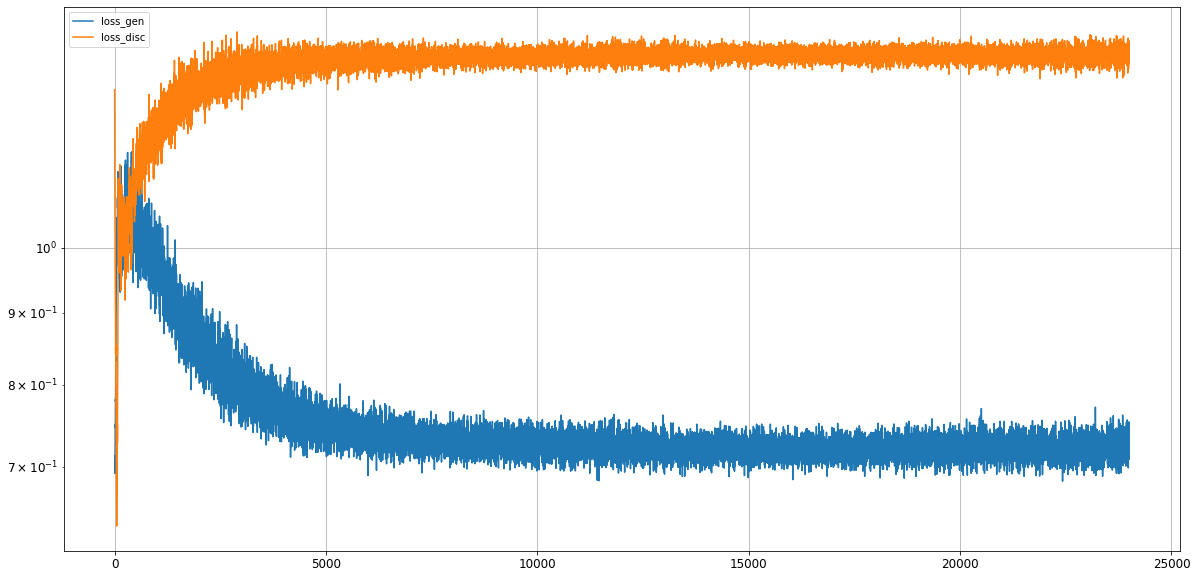

Epoch 24002/30001
generator loss:  0.7175224  -  discriminator loss:  1.36912
Epoch 24003/30001
generator loss:  0.72320133  -  discriminator loss:  1.376697
Epoch 24004/30001
generator loss:  0.70952123  -  discriminator loss:  1.3828894
Epoch 24005/30001
generator loss:  0.7131834  -  discriminator loss:  1.3587828
Epoch 24006/30001
generator loss:  0.69952697  -  discriminator loss:  1.371446
Epoch 24007/30001
generator loss:  0.70570046  -  discriminator loss:  1.3834596
Epoch 24008/30001
generator loss:  0.7014678  -  discriminator loss:  1.3879567
Epoch 24009/30001
generator loss:  0.7047747  -  discriminator loss:  1.3707328
Epoch 24010/30001
generator loss:  0.70948154  -  discriminator loss:  1.3562999
Epoch 24011/30001
generator loss:  0.7293518  -  discriminator loss:  1.3632447
Epoch 24012/30001
generator loss:  0.7163566  -  discriminator loss:  1.3572288
Epoch 24013/30001
generator loss:  0.72540617  -  discriminator loss:  1.3509063
Epoch 24014/30001
generator loss:  0.7

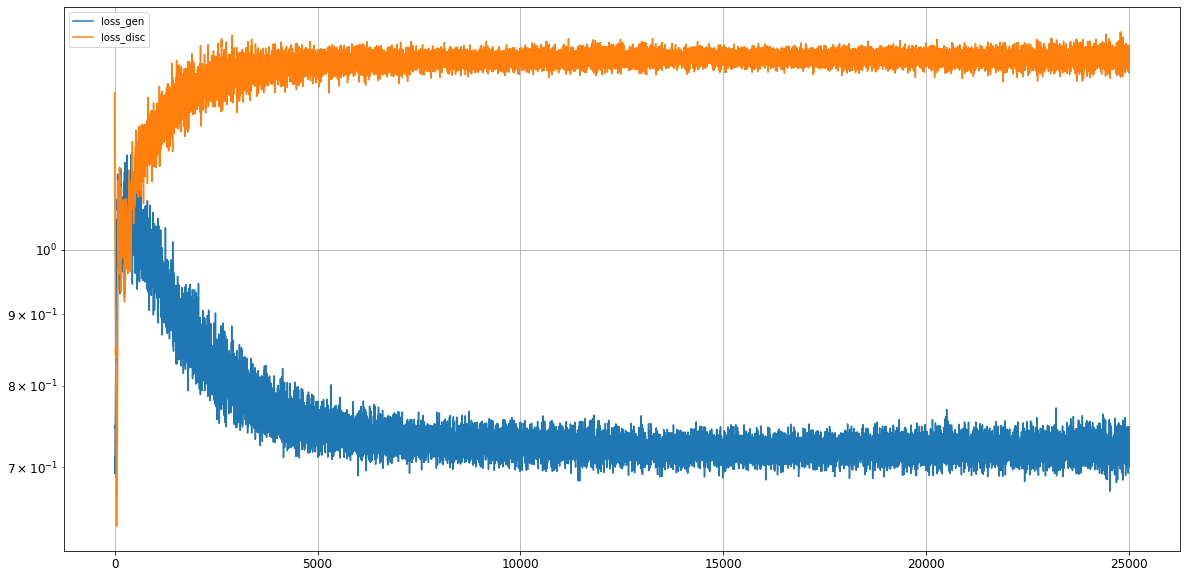

Epoch 25002/30001
generator loss:  0.7340593  -  discriminator loss:  1.3449804
Epoch 25003/30001
generator loss:  0.7288477  -  discriminator loss:  1.3291184
Epoch 25004/30001
generator loss:  0.73165745  -  discriminator loss:  1.33996
Epoch 25005/30001
generator loss:  0.7535394  -  discriminator loss:  1.3404006
Epoch 25006/30001
generator loss:  0.7409539  -  discriminator loss:  1.3462653
Epoch 25007/30001
generator loss:  0.7336461  -  discriminator loss:  1.3443255
Epoch 25008/30001
generator loss:  0.72125846  -  discriminator loss:  1.383984
Epoch 25009/30001
generator loss:  0.71569014  -  discriminator loss:  1.3754333
Epoch 25010/30001
generator loss:  0.7172239  -  discriminator loss:  1.3824929
Epoch 25011/30001
generator loss:  0.70901304  -  discriminator loss:  1.3882033
Epoch 25012/30001
generator loss:  0.69085574  -  discriminator loss:  1.4074401
Epoch 25013/30001
generator loss:  0.67527056  -  discriminator loss:  1.4052067
Epoch 25014/30001
generator loss:  0.

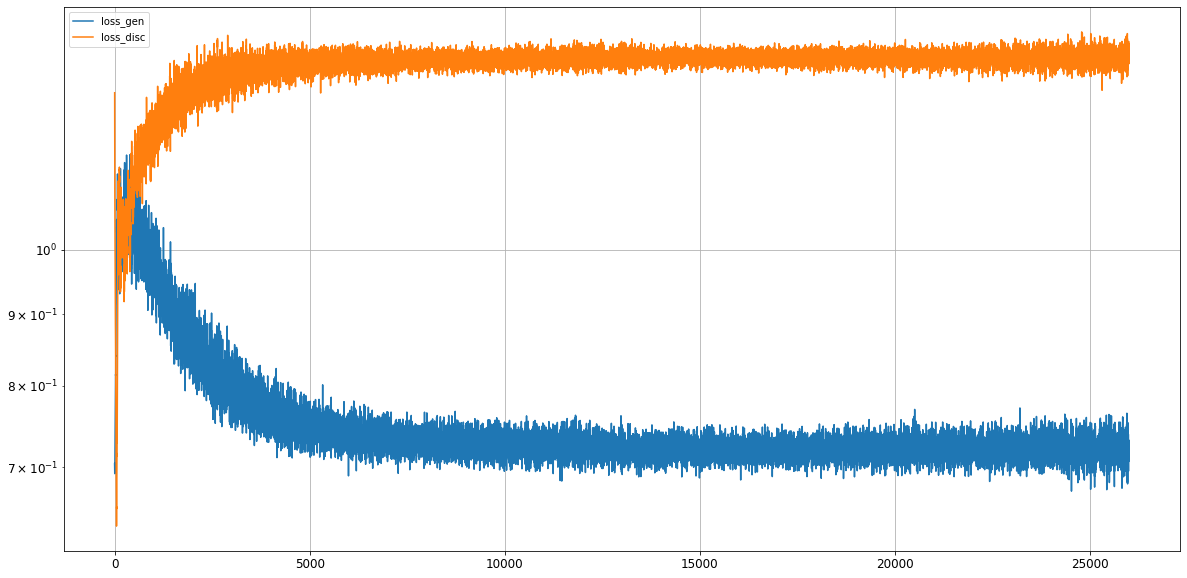

Epoch 26002/30001
generator loss:  0.71122724  -  discriminator loss:  1.3810848
Epoch 26003/30001
generator loss:  0.7131722  -  discriminator loss:  1.3915685
Epoch 26004/30001
generator loss:  0.7131872  -  discriminator loss:  1.3688701
Epoch 26005/30001
generator loss:  0.7015031  -  discriminator loss:  1.37319
Epoch 26006/30001
generator loss:  0.73014  -  discriminator loss:  1.400266
Epoch 26007/30001
generator loss:  0.7328736  -  discriminator loss:  1.4045806
Epoch 26008/30001
generator loss:  0.7275999  -  discriminator loss:  1.3953811
Epoch 26009/30001
generator loss:  0.72487944  -  discriminator loss:  1.3925854
Epoch 26010/30001
generator loss:  0.71940297  -  discriminator loss:  1.3722612
Epoch 26011/30001
generator loss:  0.7226227  -  discriminator loss:  1.3722261
Epoch 26012/30001
generator loss:  0.7442677  -  discriminator loss:  1.3594736
Epoch 26013/30001
generator loss:  0.74266905  -  discriminator loss:  1.3547665
Epoch 26014/30001
generator loss:  0.7469

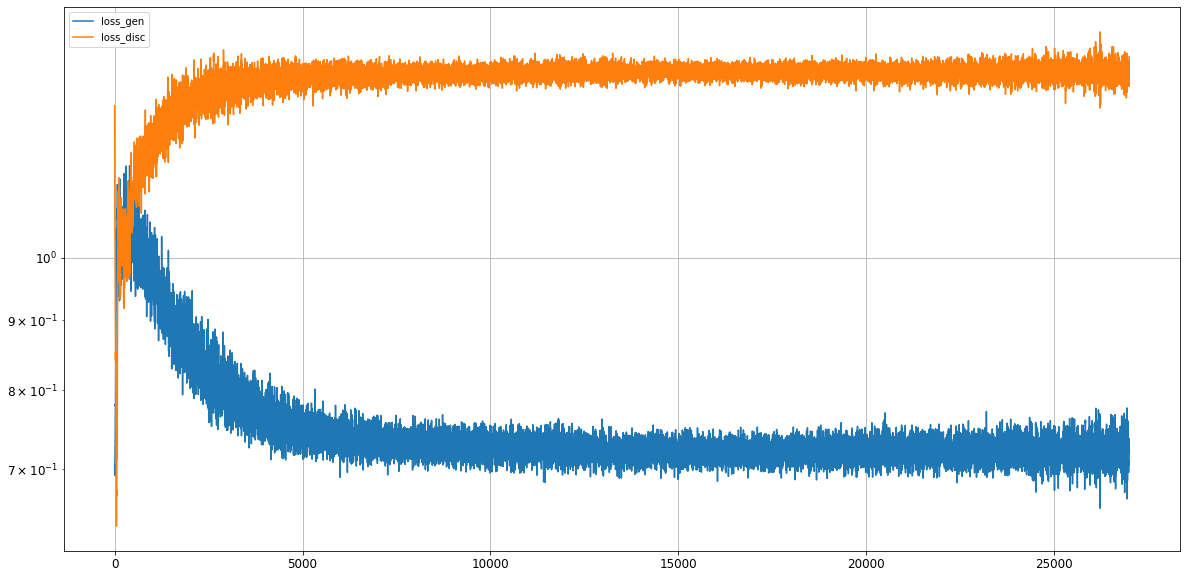

Epoch 27002/30001
generator loss:  0.7232321  -  discriminator loss:  1.385986
Epoch 27003/30001
generator loss:  0.71062684  -  discriminator loss:  1.3977438
Epoch 27004/30001
generator loss:  0.7295148  -  discriminator loss:  1.400935
Epoch 27005/30001
generator loss:  0.7322646  -  discriminator loss:  1.3930494
Epoch 27006/30001
generator loss:  0.73336476  -  discriminator loss:  1.3784
Epoch 27007/30001
generator loss:  0.7236176  -  discriminator loss:  1.3613992
Epoch 27008/30001
generator loss:  0.7196873  -  discriminator loss:  1.369576
Epoch 27009/30001
generator loss:  0.7444985  -  discriminator loss:  1.3502054
Epoch 27010/30001
generator loss:  0.7669392  -  discriminator loss:  1.3670169
Epoch 27011/30001
generator loss:  0.7586964  -  discriminator loss:  1.3343428
Epoch 27012/30001
generator loss:  0.7516048  -  discriminator loss:  1.3482808
Epoch 27013/30001
generator loss:  0.7527223  -  discriminator loss:  1.3338226
Epoch 27014/30001
generator loss:  0.7447862

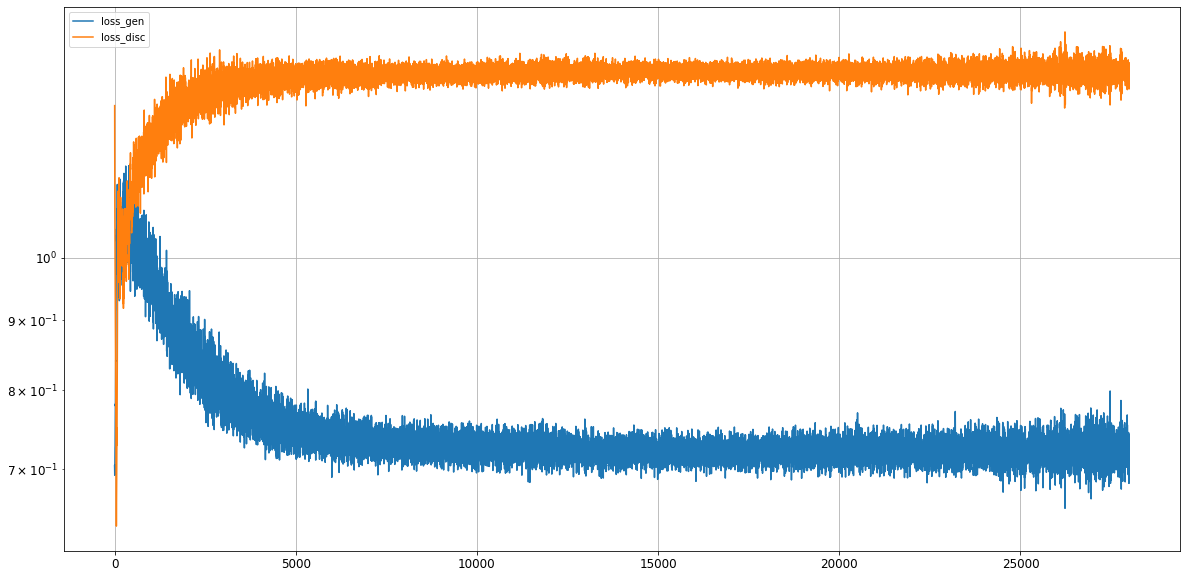

Epoch 28002/30001
generator loss:  0.74569076  -  discriminator loss:  1.3625795
Epoch 28003/30001
generator loss:  0.7186163  -  discriminator loss:  1.3322241
Epoch 28004/30001
generator loss:  0.7124557  -  discriminator loss:  1.3501457
Epoch 28005/30001
generator loss:  0.72671765  -  discriminator loss:  1.3731958
Epoch 28006/30001
generator loss:  0.7408593  -  discriminator loss:  1.3813845
Epoch 28007/30001
generator loss:  0.72547466  -  discriminator loss:  1.3945371
Epoch 28008/30001
generator loss:  0.7242007  -  discriminator loss:  1.3853406
Epoch 28009/30001
generator loss:  0.7209487  -  discriminator loss:  1.3761739
Epoch 28010/30001
generator loss:  0.7173384  -  discriminator loss:  1.3824238
Epoch 28011/30001
generator loss:  0.7438786  -  discriminator loss:  1.3698772
Epoch 28012/30001
generator loss:  0.7502866  -  discriminator loss:  1.3752025
Epoch 28013/30001
generator loss:  0.735421  -  discriminator loss:  1.3724686
Epoch 28014/30001
generator loss:  0.7

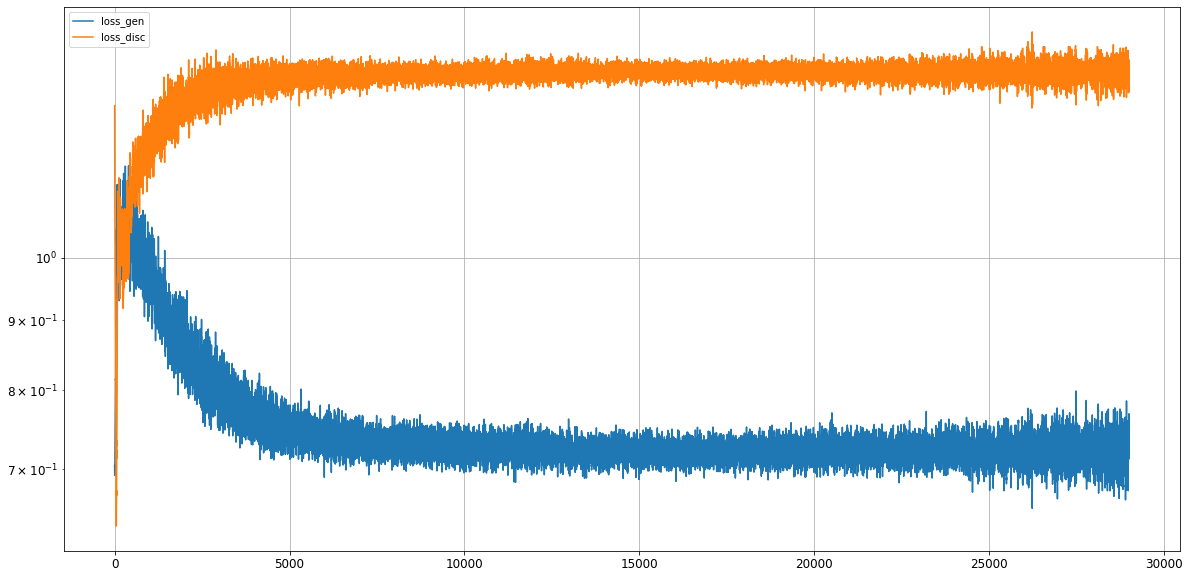

Epoch 29002/30001
generator loss:  0.72225934  -  discriminator loss:  1.3916264
Epoch 29003/30001
generator loss:  0.704854  -  discriminator loss:  1.3999375
Epoch 29004/30001
generator loss:  0.71132946  -  discriminator loss:  1.3670582
Epoch 29005/30001
generator loss:  0.7035646  -  discriminator loss:  1.4121114
Epoch 29006/30001
generator loss:  0.69760936  -  discriminator loss:  1.4112922
Epoch 29007/30001
generator loss:  0.6808104  -  discriminator loss:  1.3950753
Epoch 29008/30001
generator loss:  0.6834484  -  discriminator loss:  1.4290571
Epoch 29009/30001
generator loss:  0.6684564  -  discriminator loss:  1.4080108
Epoch 29010/30001
generator loss:  0.68694615  -  discriminator loss:  1.3940471
Epoch 29011/30001
generator loss:  0.692679  -  discriminator loss:  1.3946224
Epoch 29012/30001
generator loss:  0.69764894  -  discriminator loss:  1.3832631
Epoch 29013/30001
generator loss:  0.70284915  -  discriminator loss:  1.40451
Epoch 29014/30001
generator loss:  0.7

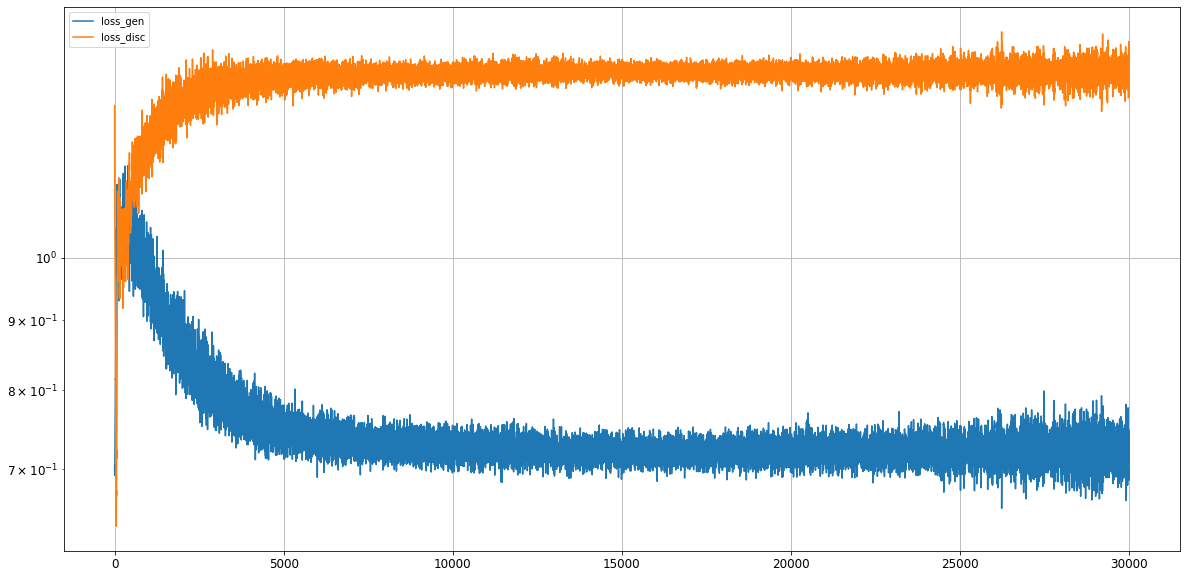

In [ ]:
hist = train(train_dataset, epochs=30001)

## Plot out the final loss of generator and discriminator

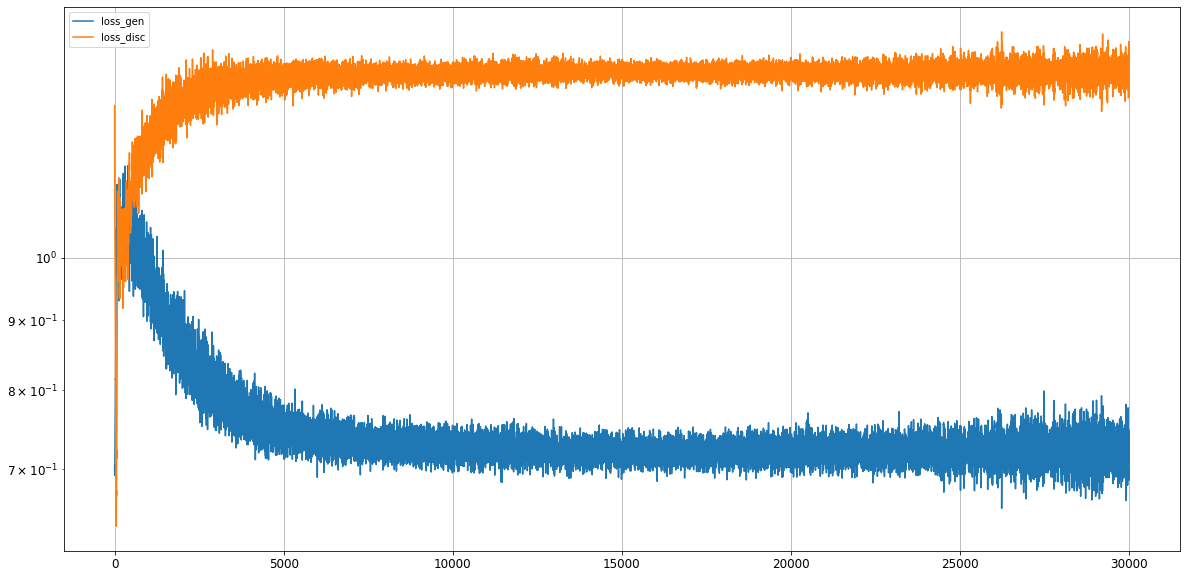

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc']) 
ax.set_yscale('log')
ax.grid()

In [ ]:
# save GAN model for Pred-GAN later
from tensorflow.keras.models import load_model
gan.save("gan-sfc-824-afternoon44-30000.h5")

## Discussion of GAN model

Refer to discussion in the report. 